### Importing Libraries

In [68]:
import numpy as np
import pandas as pd

import networkx as nx
from networkx.algorithms import bipartite

import matplotlib.pyplot as plt

import random

from pyomo.environ import ConcreteModel, Var, Objective, Constraint, SolverFactory, Binary, maximize
from scipy.optimize import minimize
from itertools import combinations

import qiskit
from qiskit import QuantumCircuit, ClassicalRegister, QuantumRegister, transpile
from qiskit.visualization import *
from qiskit_aer import AerSimulator
#from qiskit.aqua.components import optimizers

In [77]:
donors = 3
recipients = 4
#G = nx.complete_bipartite_graph(donors, recipients)
G = nx.bipartite.random_graph(donors, recipients, p = 0.5)
weighted = True

for (u, v) in G.edges():
    if weighted:
        w = random.uniform(0, 1)
    else:
        w = 1
    G.edges[u, v]['weight'] = w

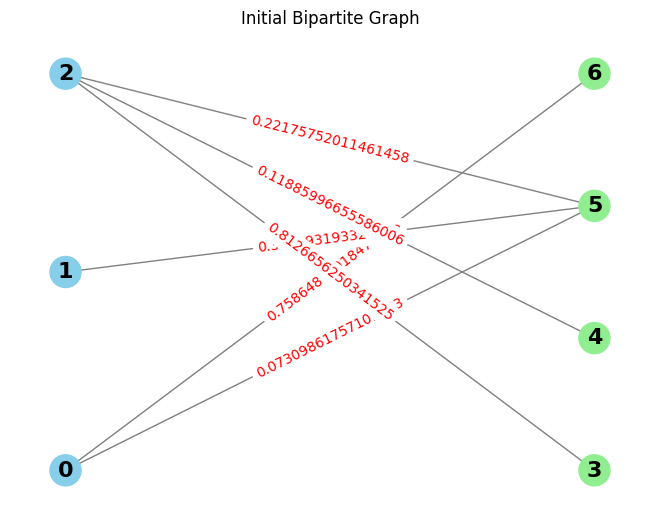

In [78]:
pos = nx.bipartite_layout(G, nodes=set(range(donors)))
nx.draw(G, pos, with_labels=True, node_color=['skyblue']*donors + ['lightgreen']*recipients, node_size=500, font_size=16, font_weight='bold', edge_color='gray')

# Draw edge labels (weights)
edge_labels = nx.get_edge_attributes(G, 'weight')
nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels, font_color='red')

# Show the plot
plt.title("Initial Bipartite Graph")
plt.show()

### Creating the Basic Set-Up

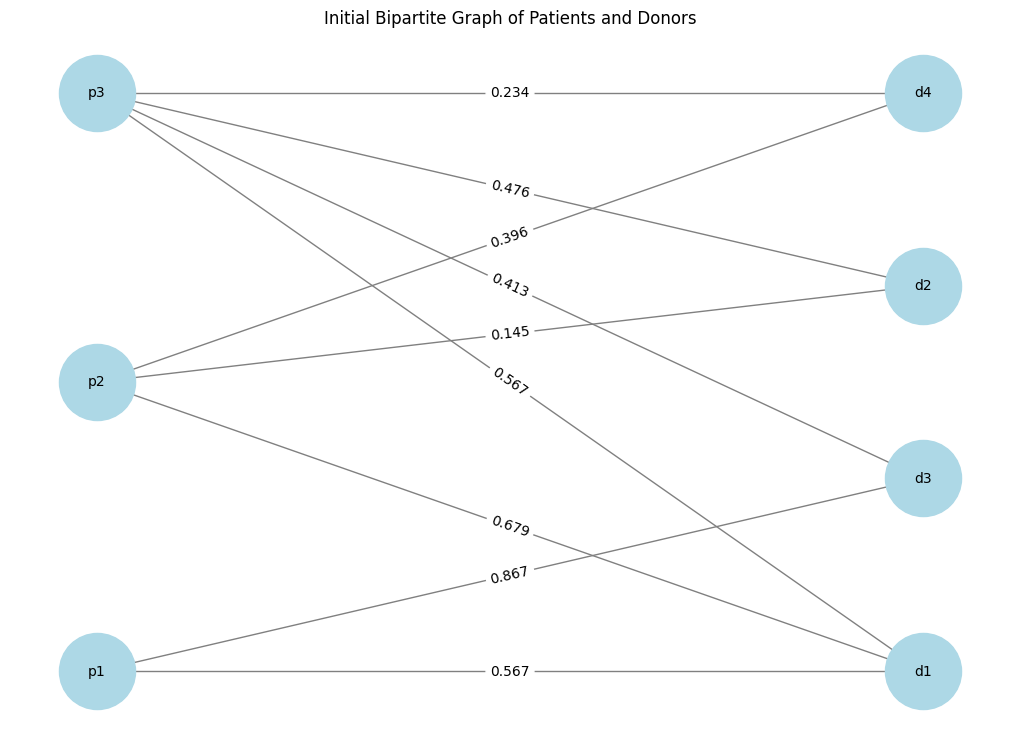

"\n    df = pd.read_csv('patient-donor.csv', delimiter=';')\n\n    # Create a graph\n    G = nx.Graph()\n\n    patients = df.index[1:].tolist()\n\n    donors = df.columns.tolist()\n\n    G.add_nodes_from(patients, bipartite=0)\n    G.add_nodes_from(donors, bipartite=1)\n\n    for patient in patients:\n        for donor in donors:\n            weight = df.at[patient, donor]\n            if pd.notna(weight) and weight.strip():  # Ensure weight is not NaN and not empty\n                try:\n                    weight = float(weight)  # Convert weight to float\n                    G.add_edge(patient, donor, weight=weight)\n                except ValueError:\n                    pass\n    pos = nx.bipartite_layout(G, patients)\n\n    nx.draw(G, pos, with_labels=True)\n\n    # Draw edge labels (weights)\n    edge_labels = nx.get_edge_attributes(G, 'weight')\n    nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels)\n\n    # Show the plot\n    plt.show()\n\n"

In [36]:
 
'''
In case data is given in patient-donor-weight format following fetching method can be used instead of the uncommented 
code below:

    
df = pd.read_csv('patient-donor2.csv', delimiter=';')

# Extract number of unique donors and recipients
donors = df['donor'].nunique()
recipients = df['patient'].nunique()

# Create a bipartite graph
G = nx.Graph()

# Add nodes with the bipartite attribute
G.add_nodes_from(df['patient'], bipartite=0)  # Patients
G.add_nodes_from(df['donor'], bipartite=1)    # Donors

# Add edges with weights
for index, row in df.iterrows():
    G.add_edge(row['patient'], row['donor'], weight=row['weight'])

# Define positions for bipartite layout
pos = nx.bipartite_layout(G, nodes=df['patient'].unique())

# Draw the graph
plt.figure(figsize=(10, 7))  # Adjust the size as needed
nx.draw(G, pos, with_labels=True, node_color='lightblue', edge_color='gray', node_size=3000, font_size=10)

# Draw edge labels (weights)
edge_labels = nx.get_edge_attributes(G, 'weight')
nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels)

# Display the graph
plt.title('Initial Bipartite Graph of Patients and Donors')
plt.show()


    df = pd.read_csv('patient-donor.csv', delimiter=';')

    # Create a graph
    G = nx.Graph()

    patients = df.index[1:].tolist()

    donors = df.columns.tolist()

    G.add_nodes_from(patients, bipartite=0)
    G.add_nodes_from(donors, bipartite=1)

    for patient in patients:
        for donor in donors:
            weight = df.at[patient, donor]
            if pd.notna(weight) and weight.strip():  # Ensure weight is not NaN and not empty
                try:
                    weight = float(weight)  # Convert weight to float
                    G.add_edge(patient, donor, weight=weight)
                except ValueError:
                    pass
    pos = nx.bipartite_layout(G, patients)

    nx.draw(G, pos, with_labels=True)

    # Draw edge labels (weights)
    edge_labels = nx.get_edge_attributes(G, 'weight')
    nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels)

    # Show the plot
    plt.show()

'''

### Creating Models

In [51]:
print(list(G.nodes(data=True)))

[(0, {'bipartite': 0}), (1, {'bipartite': 0}), (2, {'bipartite': 0}), (3, {'bipartite': 1}), (4, {'bipartite': 1}), (5, {'bipartite': 1}), (6, {'bipartite': 1})]


In [52]:
model = ConcreteModel()

# Decision variables: x[i,j] = 1 if donor i is matched with recipient j
model.x = Var(G.edges(), within=Binary)

# Objective function: maximize the total weight of connections
def objective_rule(model):
    return sum(G.edges[i, j]['weight'] * model.x[i, j] for i, j in G.edges())
model.obj = Objective(rule=objective_rule, sense=maximize)  # Minimize negative, equivalent to maximize

#Constraints: Each donor and recipient is matched only once
def donor_constraint_rule(model, i):
    return sum(model.x[i, j] for j in G.neighbors(i) if (i, j) in model.x) <= 1
model.donor_constraint = Constraint(range(donors), rule=donor_constraint_rule)

def recipient_constraint_rule(model, j):
    return sum(model.x[i, j] for i in G.neighbors(j) if (i, j) in model.x) <= 1
model.recipient_constraint = Constraint(range(donors, donors + recipients), rule=recipient_constraint_rule)

### Creating the circuit components:

#### QAOA Parameters:

In [53]:
depth = 8
rep = 100
qubits = list(range(donors + recipients))

#### Circuit Initializaton
To initialize our circuit, Hadamard gate is applied to each qubit.

In [55]:
def initialization(qc, qubits):
    for q in qubits:
        qc.h(q)

#### Cost Hamiltonian Generator

In [56]:
def cost_unitary(qc, qubits, gamma):
    for i, j in G.edges():
        qc.cx(qubits[i], qubits[j])
        qc.rz(2 * gamma * G.edges[i, j]['weight'], qubits[j])
        qc.cx(qubits[i], qubits[j])

#### Mixer Hamiltonian Generator

In [57]:
def mixer_unitary(qc, qubits, beta):
    for q in qubits:
        qc.rx(2 * beta, q)

#### Circuit Creator
The function below uses the functions created above to generate the circuit suitable to the constraints of the problem.

In [58]:
def create_circuit(params):
    gammas = [j for i, j in enumerate(params) if i % 2 == 0]
    betas = [j for i, j in enumerate(params) if i % 2 == 1]

    qc = QuantumCircuit(donors + recipients)
    initialization(qc, qubits)

    for d in range(depth):
        cost_unitary(qc, qubits, gammas[d])
        mixer_unitary(qc, qubits, betas[d])

    qc.measure_all()
    return qc


### Calculating Cost Function:
Lower it is better it is...

In [63]:
#Connecting to the aer simulator:
aer_sim = AerSimulator(max_parallel_shots=1)

In [66]:
def cost_function(params):

    qc = create_circuit(params)

    #yeni qiskit notasyonunda devre calistirmak icin boyle yapmak gerekiyor
    transpiled_qc = transpile(qc, backend=aer_sim)
    job = aer_sim.run(qc, shots=rep)
    result = job.result()
    counts = result.get_counts()
    #counts = result.quasi_dists[0].nearest_probability_distribution()

    #print(counts)
    total_cost = 0
    for bitstring, count in counts.items():
        bit_list = [int(bit) for bit in bitstring]
        for i, j in G.edges():
            total_cost += G.edges[i, j]['weight'] * 0.5 * ((1 - 2 * bit_list[i]) * (1 - 2 * bit_list[j]) - 1) * count
    total_cost = total_cost / rep
    return total_cost

#init = np.random.uniform(-np.pi, np.pi, 2 * depth)
#ab = cost_function(init)
#print(ab)


### Experiments
Açıkçası bazı sorularım var bu kısımla ilgili GPT ile sohbet etmem lazım

In [73]:
optimal_params = None
optimal_val = np.inf

for _ in range(8):
    init = np.random.uniform(-np.pi, np.pi, 2 * depth)
    res = minimize(cost_function, x0=init, method="COBYLA", options={'maxiter':1000})
    if res.fun < optimal_val:
        optimal_params = res.x
        optimal_val = res.fun

# Run the final circuit with the optimal parameters
qc = create_circuit(optimal_params)
transpiled_circuit = transpile(qc, backend=aer_sim)
job = aer_sim.run(transpiled_circuit, shots=rep)
result = job.result()
counts = result.get_counts()

# Process the results
quantum_preds = []
for bitstring in counts:
    temp = []
    for pos, bit in enumerate(bitstring):
        if bit == '1':
            temp.append(pos)
    quantum_preds.append(temp)

# Calculate classical cuts for comparison
sub_lists = []
for i in range(donors + recipients + 1):
    temp = [list(x) for x in combinations(G.nodes(), i)]
    sub_lists.extend(temp)

cut_classic = []
for sub_list in sub_lists:
    cut_classic.append(nx.algorithms.cuts.cut_size(G, sub_list, weight='weight'))

cut_quantum = []
for cut in quantum_preds:
    cut_quantum.append(nx.algorithms.cuts.cut_size(G, cut, weight='weight'))

print("Quantum mean cut:", np.mean(cut_quantum))
print("Max classical cut:", np.max(cut_classic))
print("Ratio:", np.mean(cut_quantum) / np.max(cut_classic))

Quantum mean cut: 2.3601161913876108
Max classical cut: 4.165382649994478
Ratio: 0.5666024924242529


In [74]:
print(cut_quantum)

[3.129494033857348, 1.0387105797802283, 1.5257404541893476, 3.1468339069994893, 2.7695581249170074, 2.958749323876658, 1.2989085090742147, 2.108123327219261, 1.0387105797802283, 2.866474140920263, 2.7695581249170074, 2.6183178708080117, 3.129494033857348, 2.958749323876658, 2.8877984659173817, 2.3174572520692034, 3.1266720702142496, 2.774040810840819, 3.2610706852499383, 3.1468339069994893, 2.110945290862359, 2.297314526178912, 4.165382649994478, 2.297314526178912, 1.738152194703689, 1.9402005808816696, 4.165382649994478, 1.7140059060634723, 2.427230455290789, 2.8877984659173817, 1.3716782364372537, 1.9402005808816696, 2.4513767439310055, 2.6183178708080117, 3.1266720702142496, 2.108123327219261, 1.3716782364372537, 2.3174572520692034, 3.1053477452171308, 1.3913418391536587, 3.5832556289858655, 1.060034904777347, 1.0358886161371301, 2.0785836477723354, 1.2775841840770963, 3.1053477452171308, 2.296132927072085, 1.3958245250774706, 1.3958245250774706]


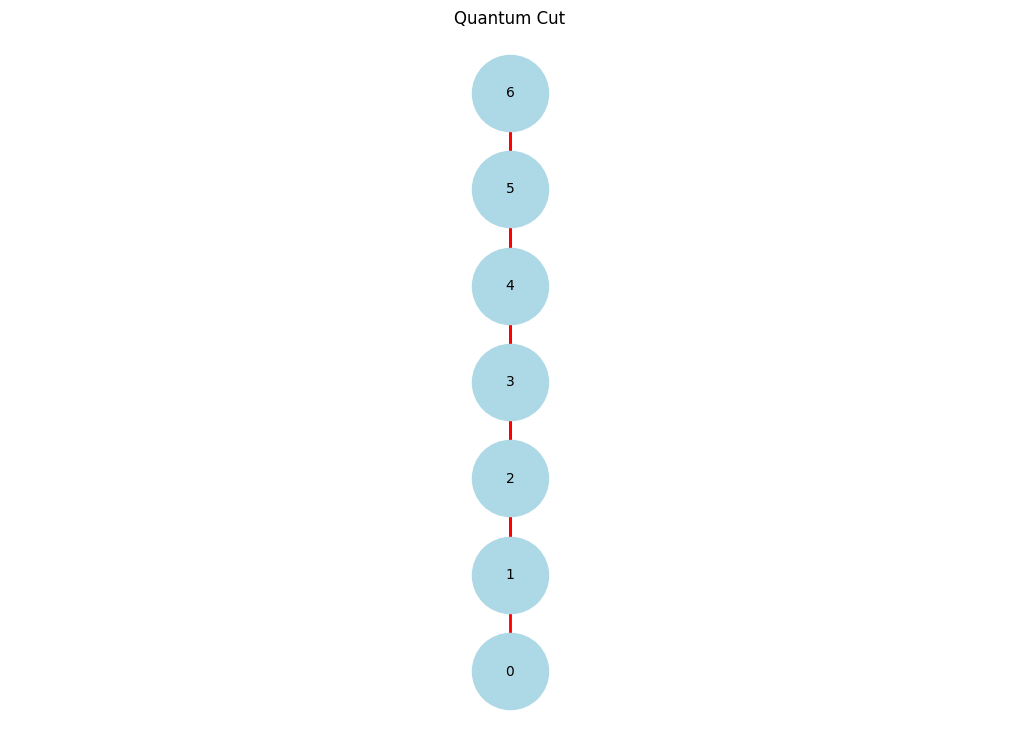

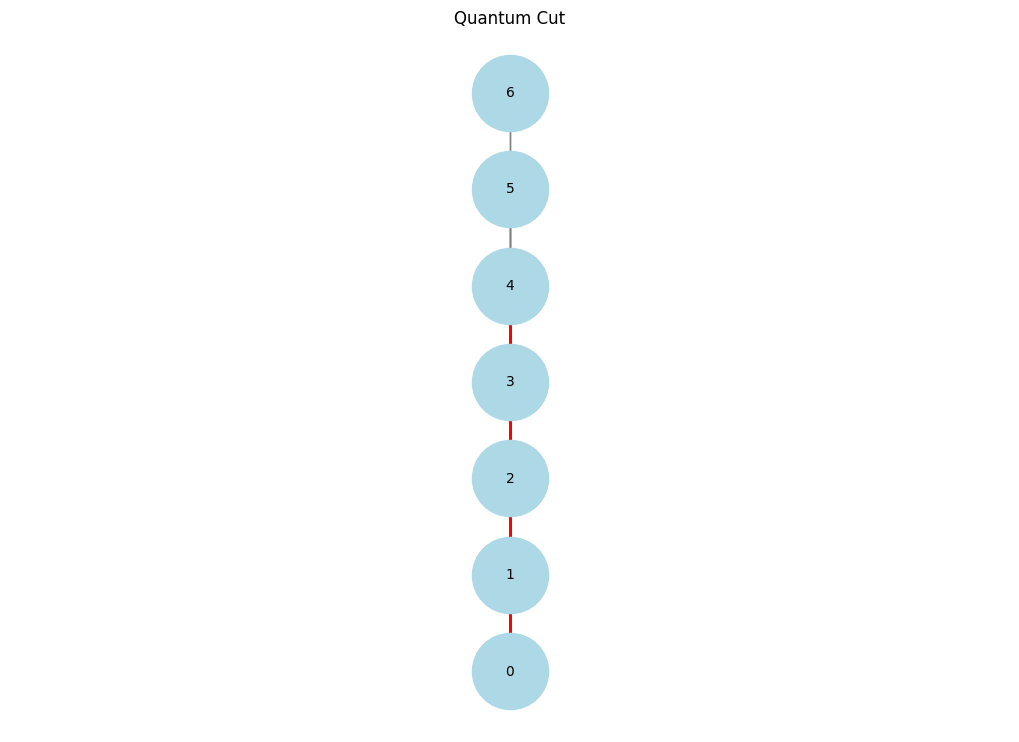

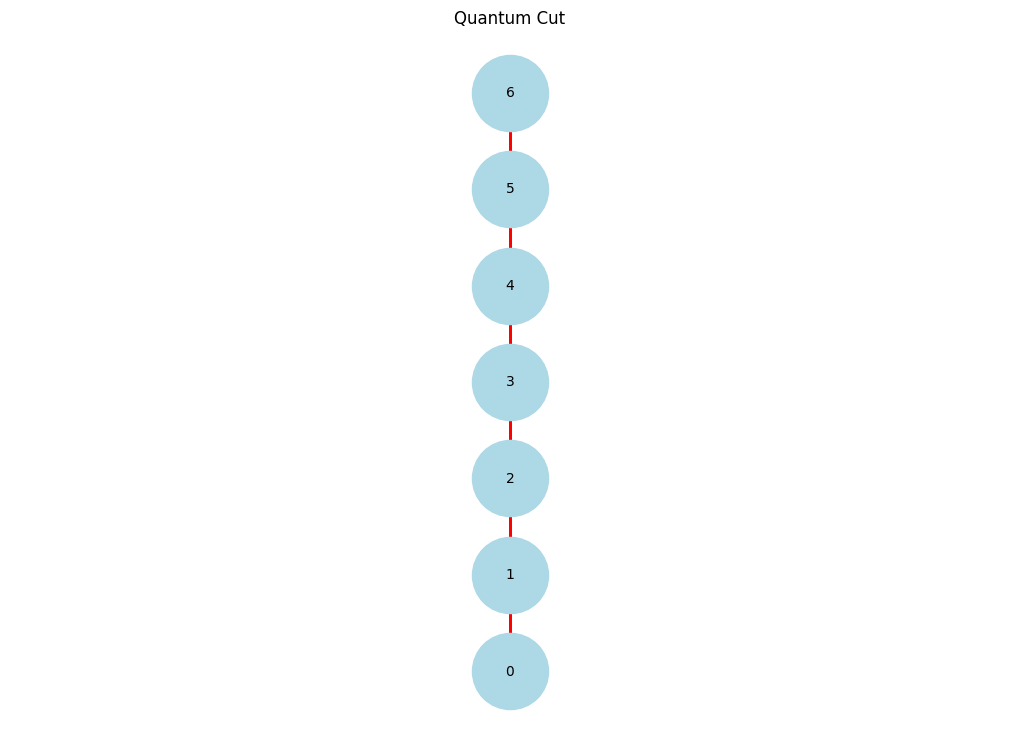

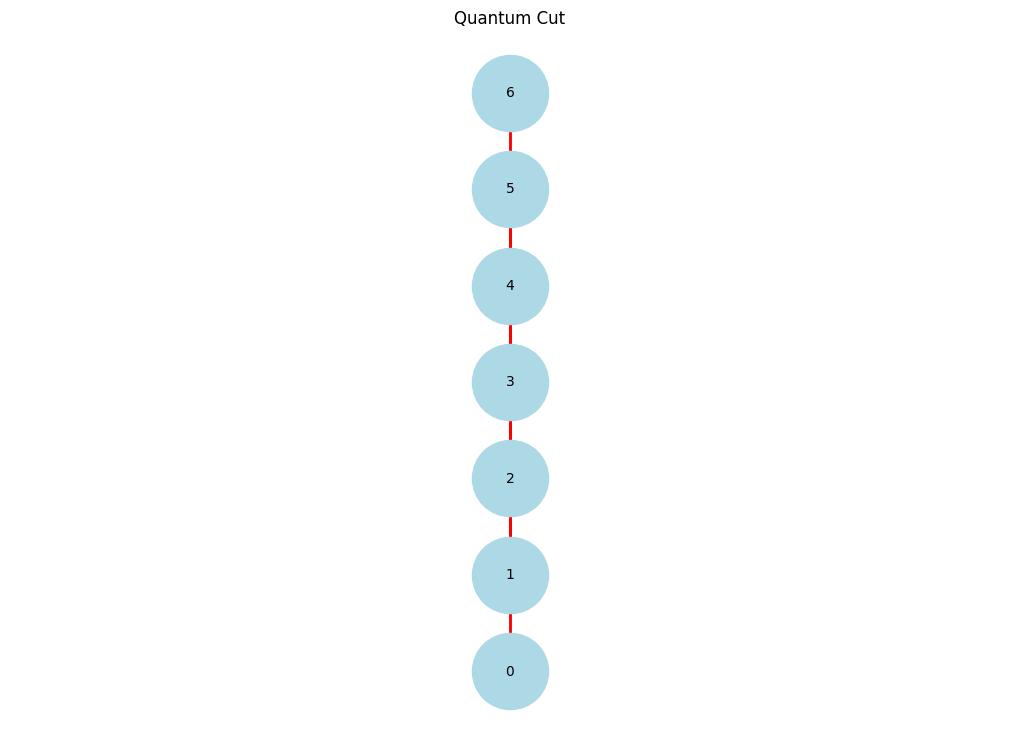

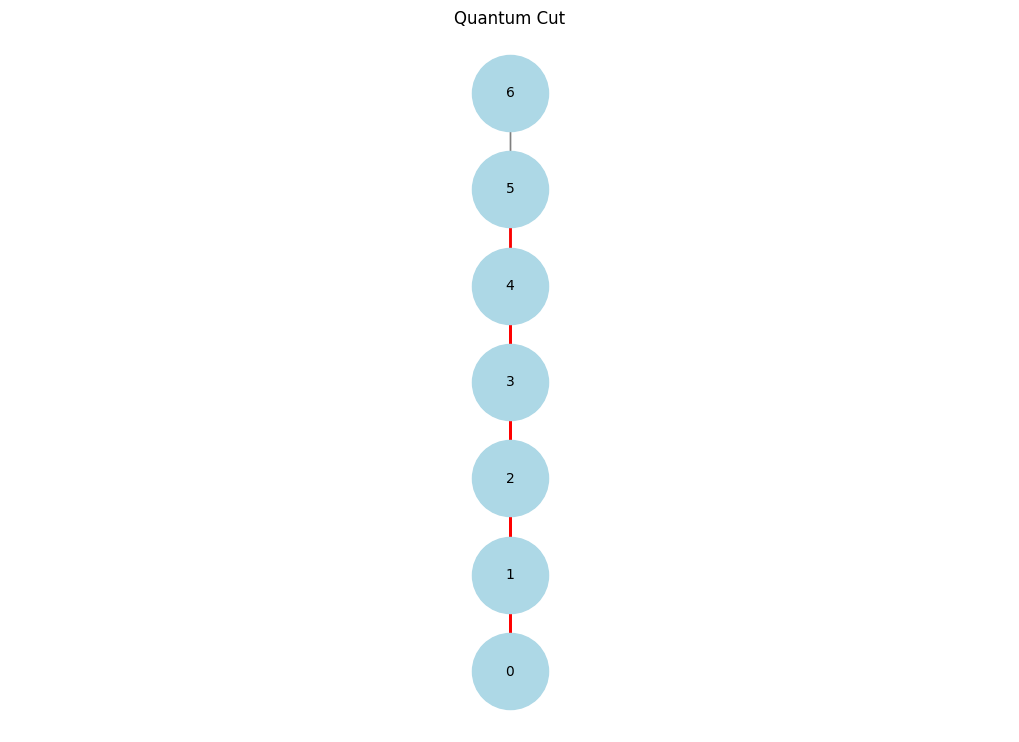

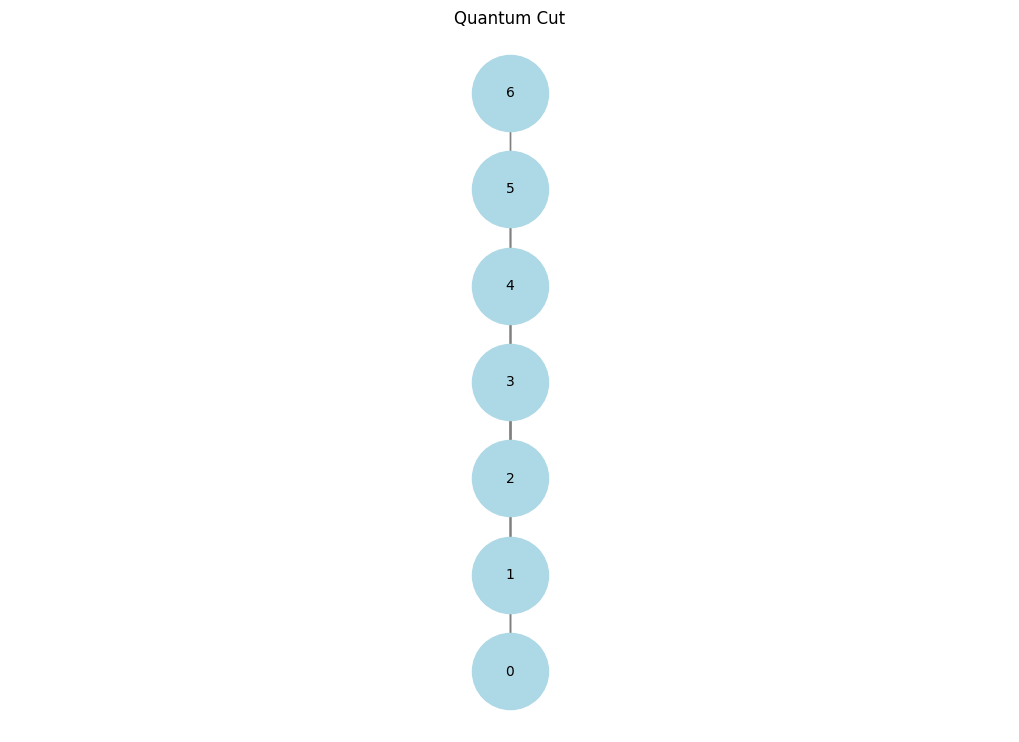

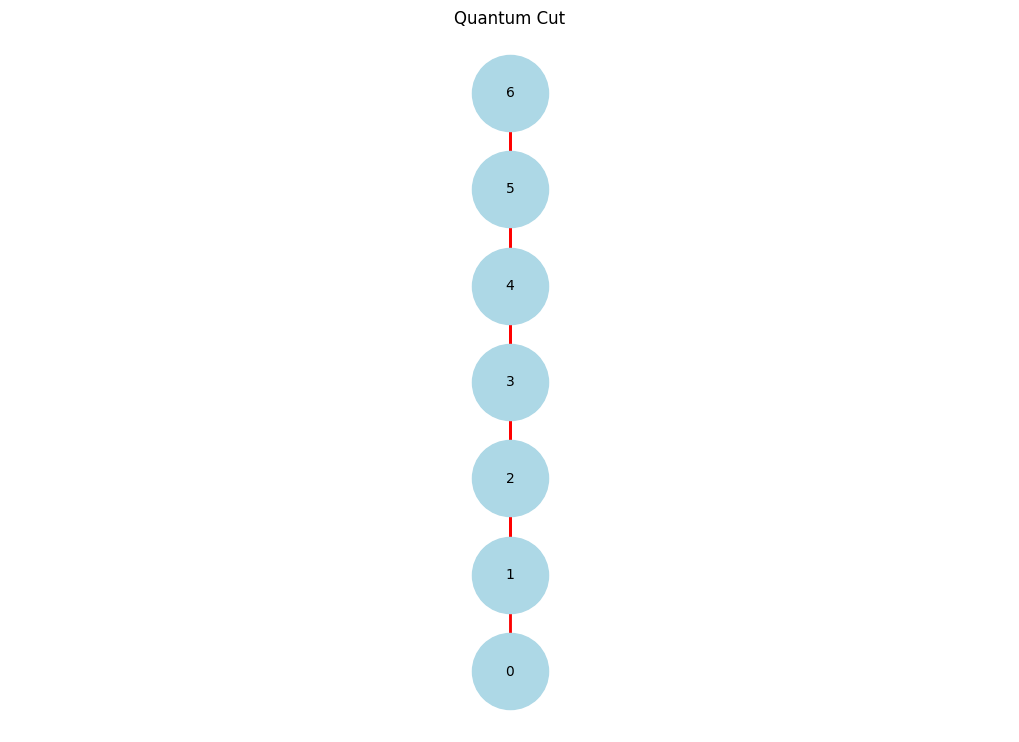

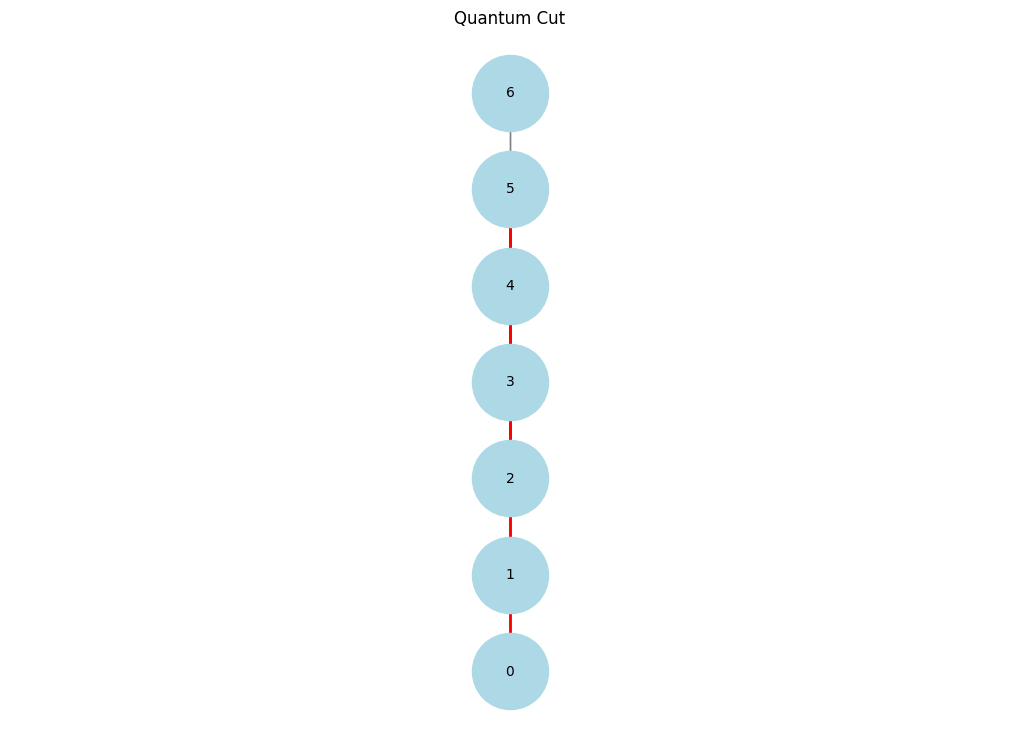

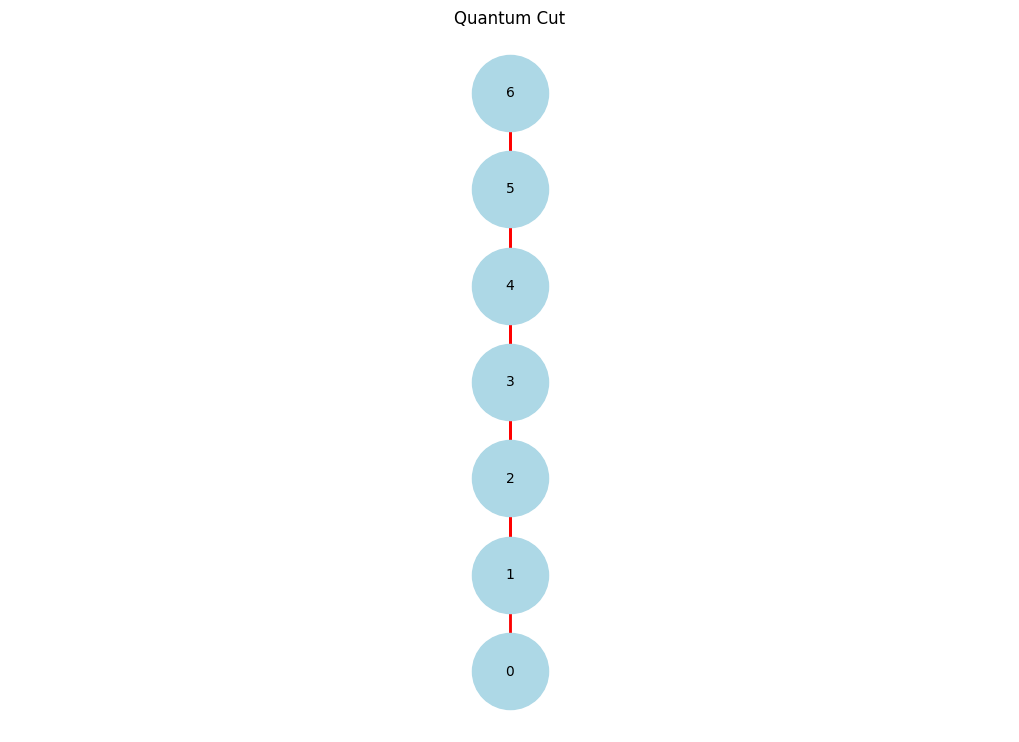

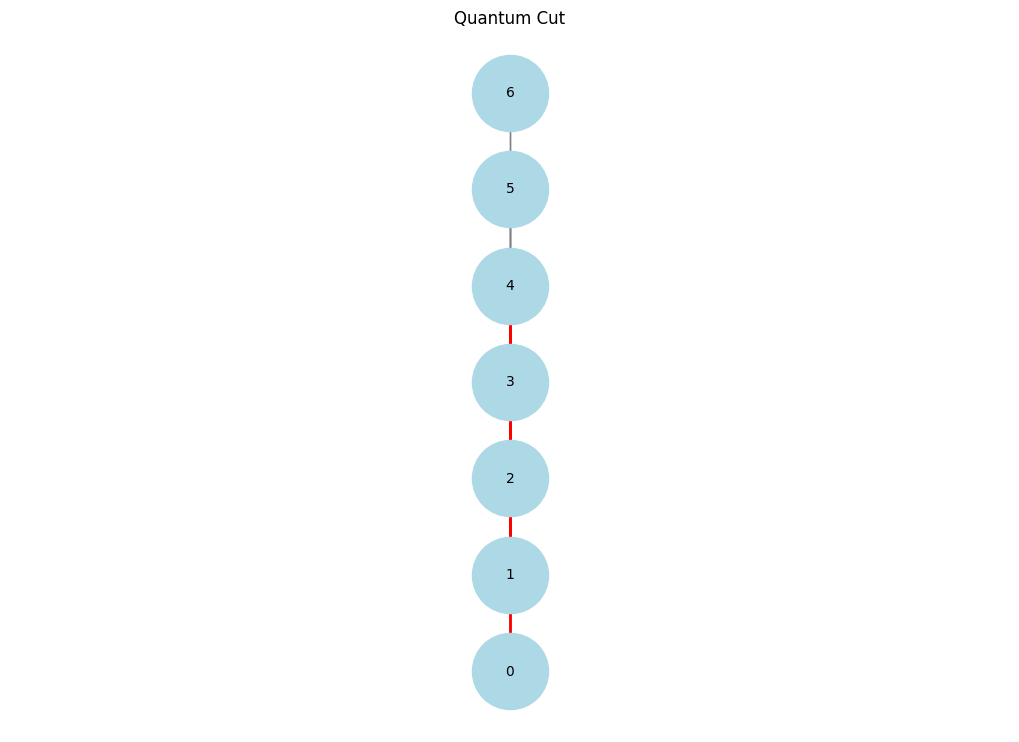

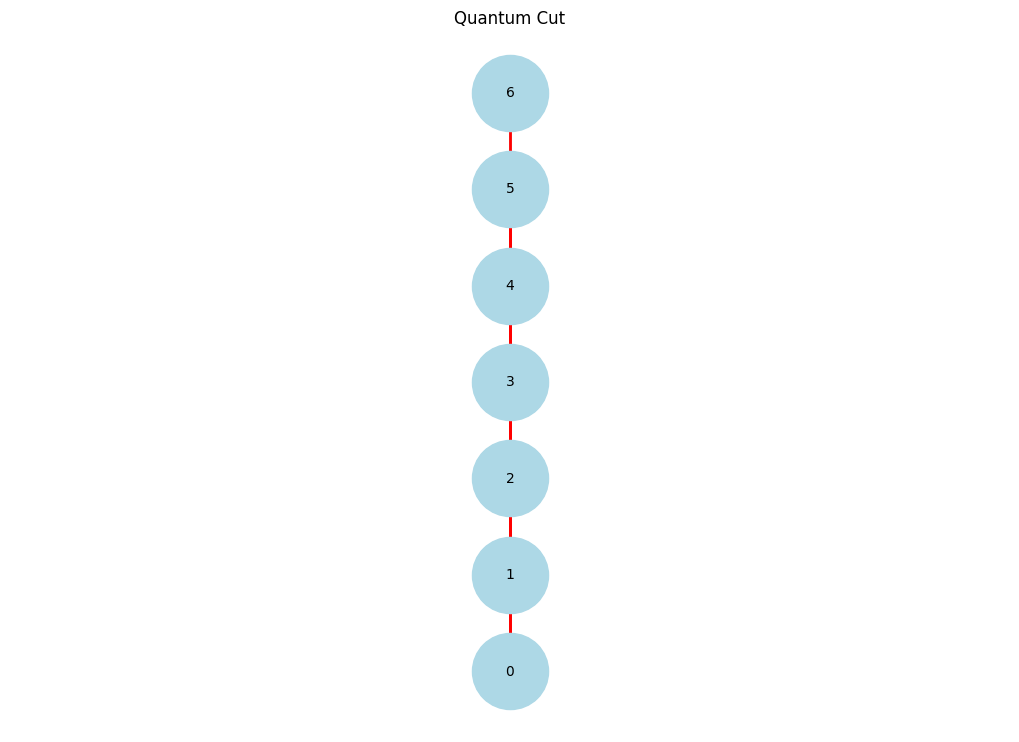

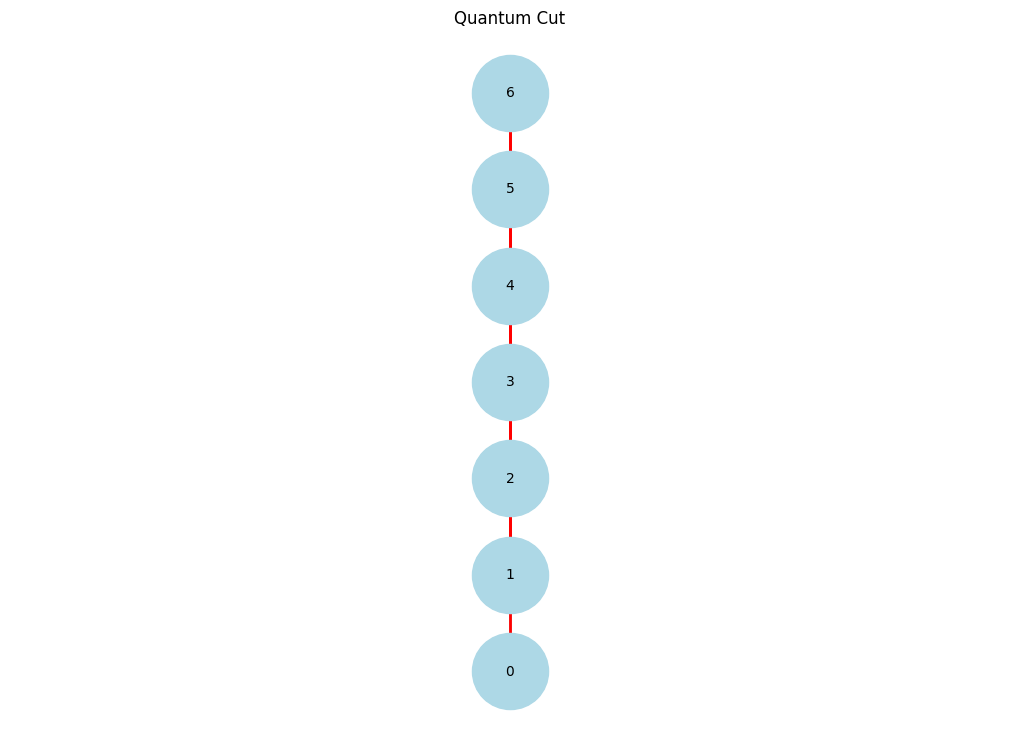

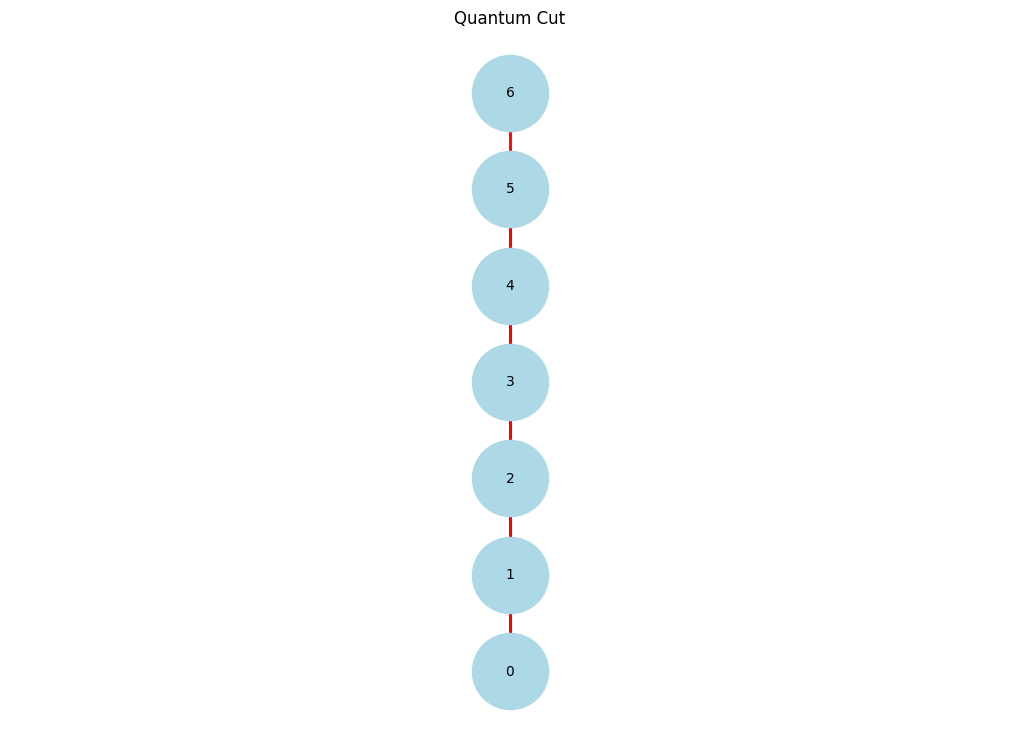

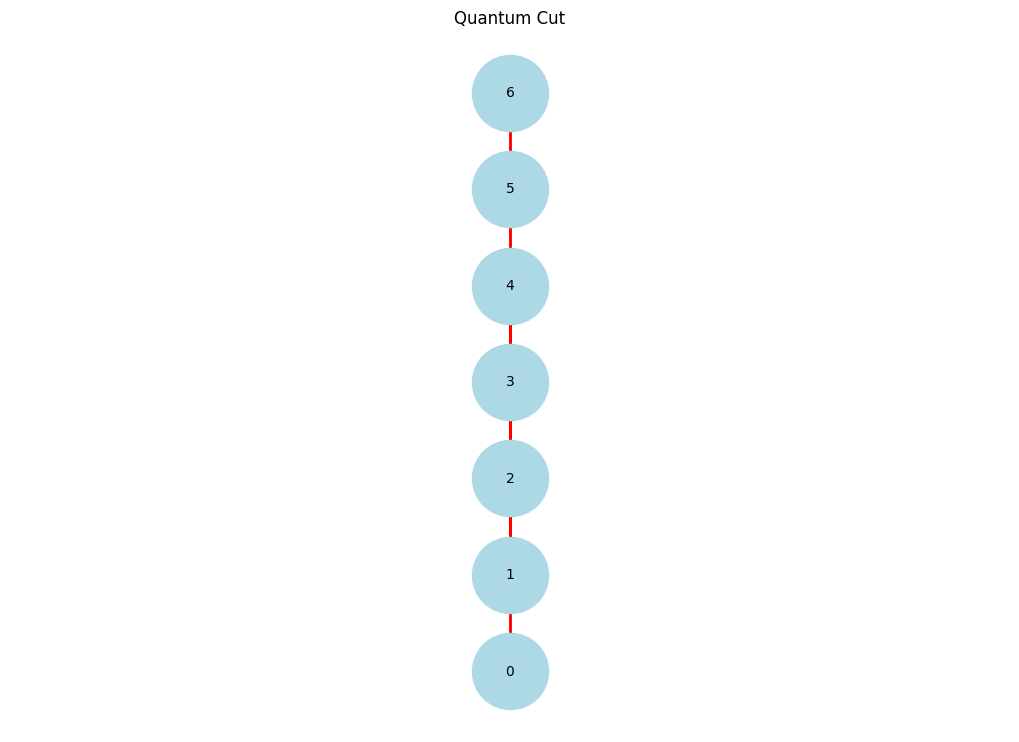

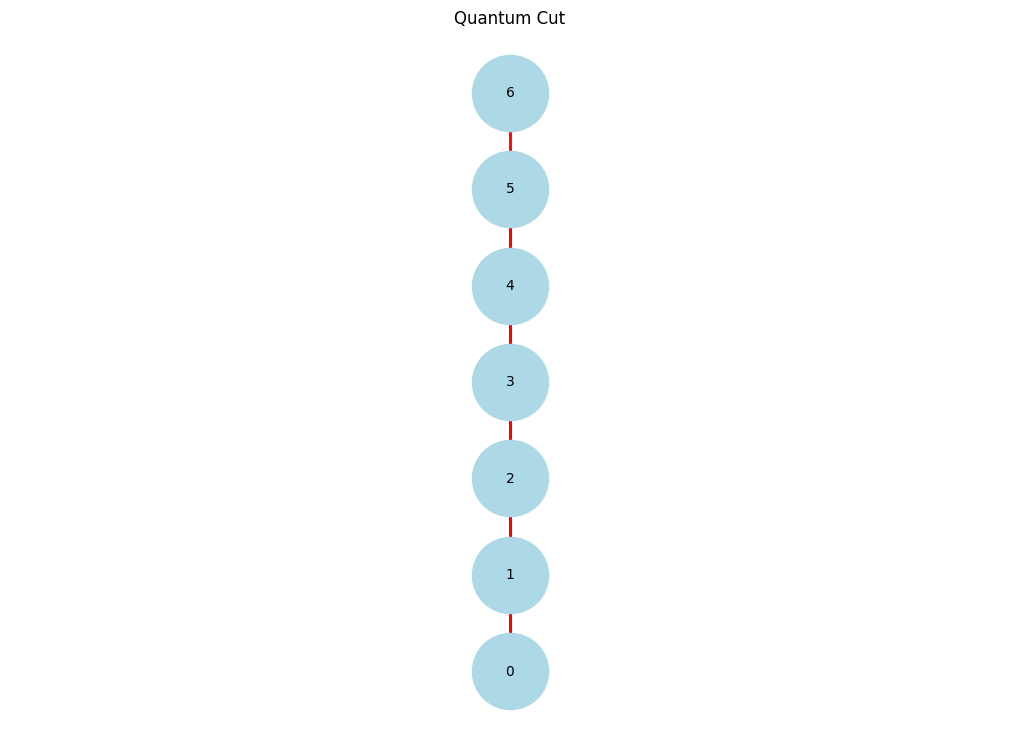

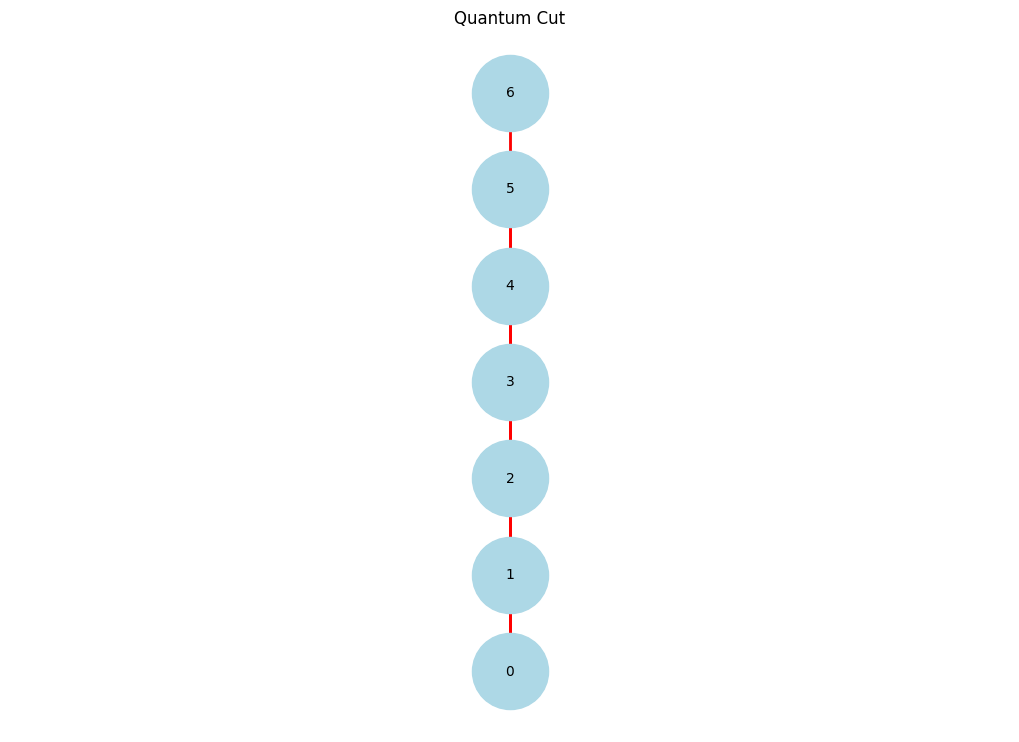

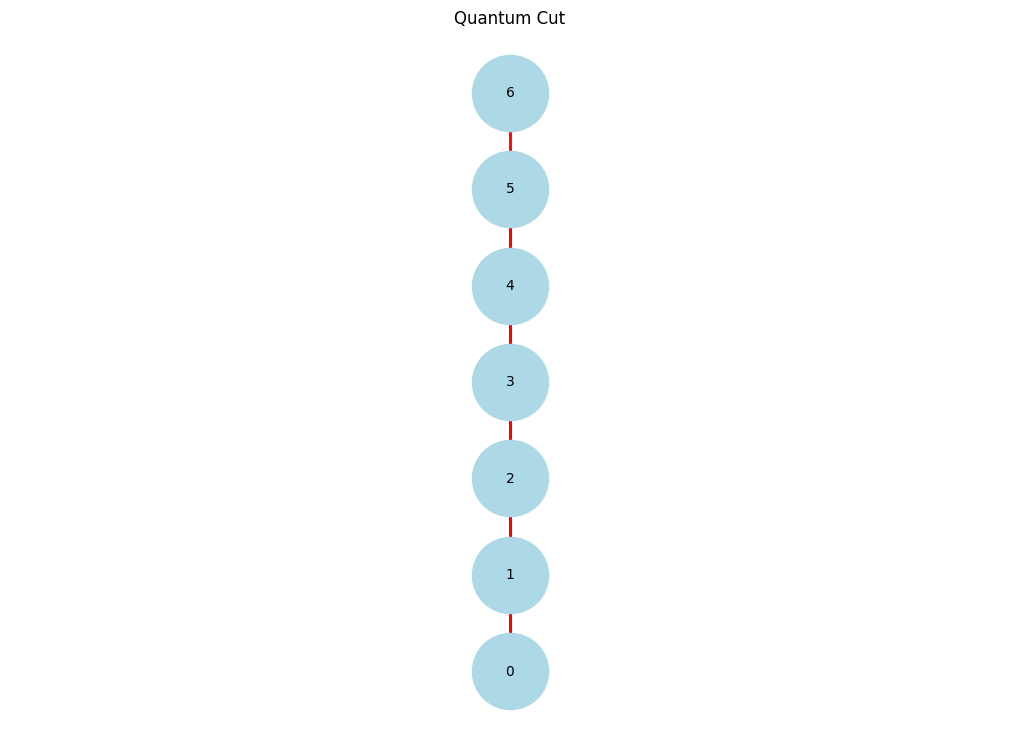

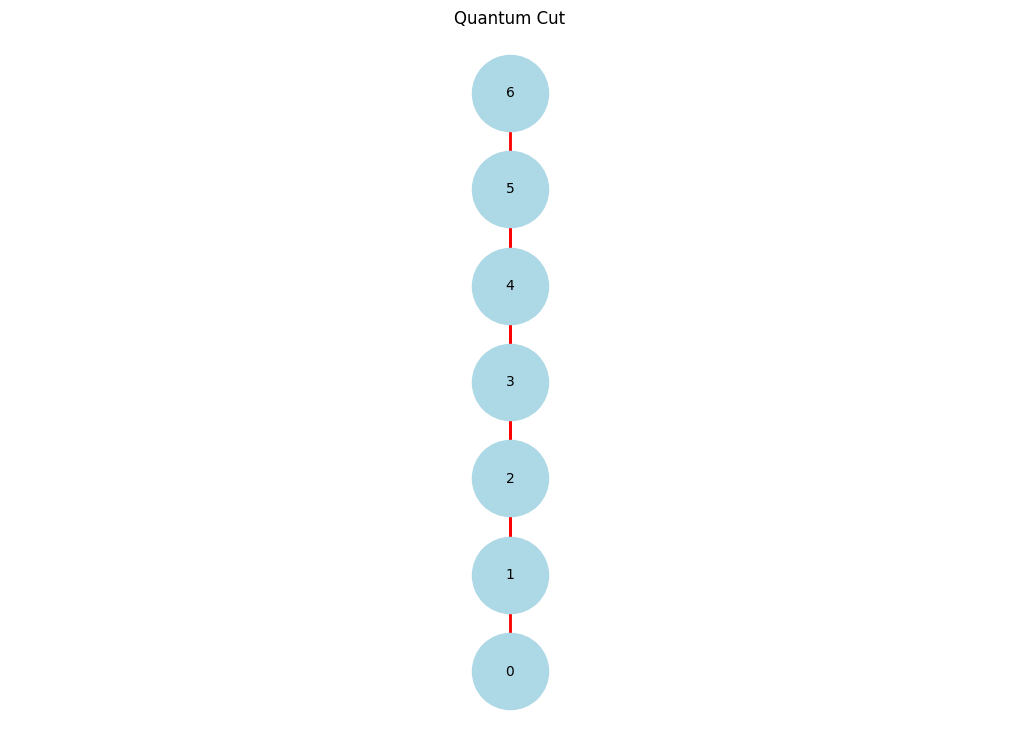

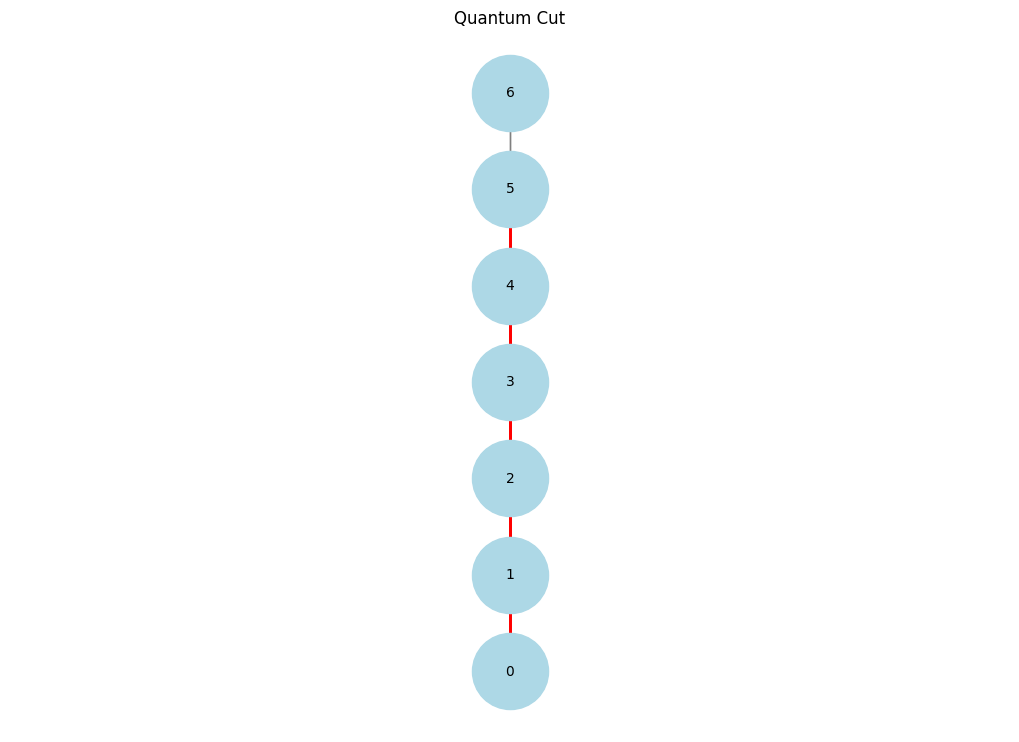

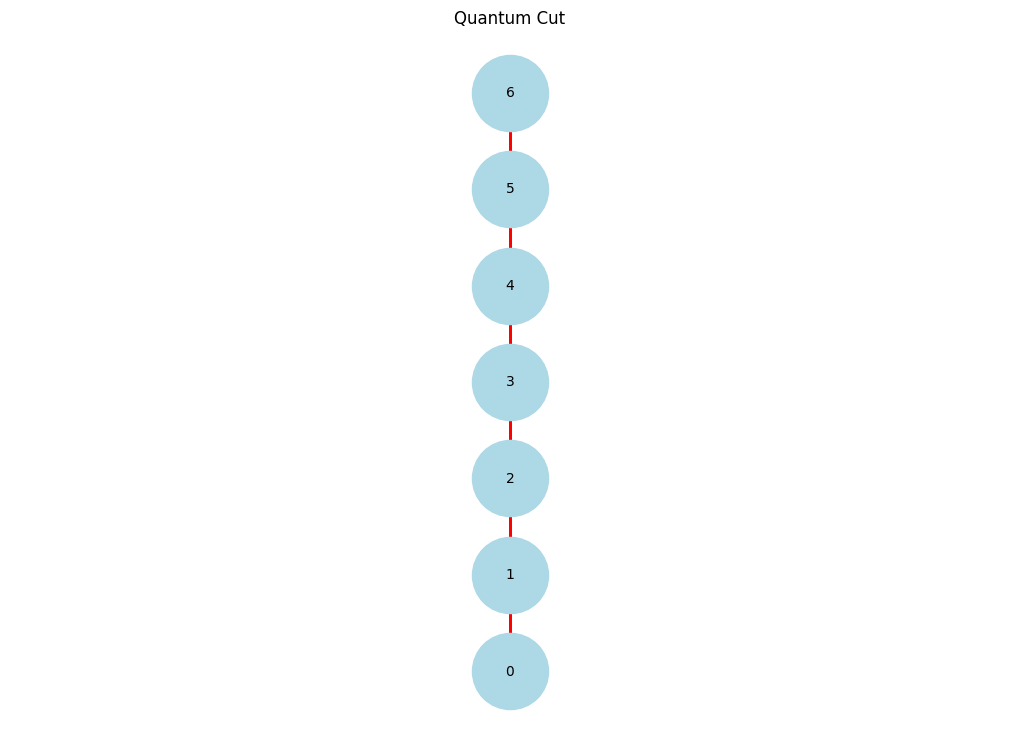

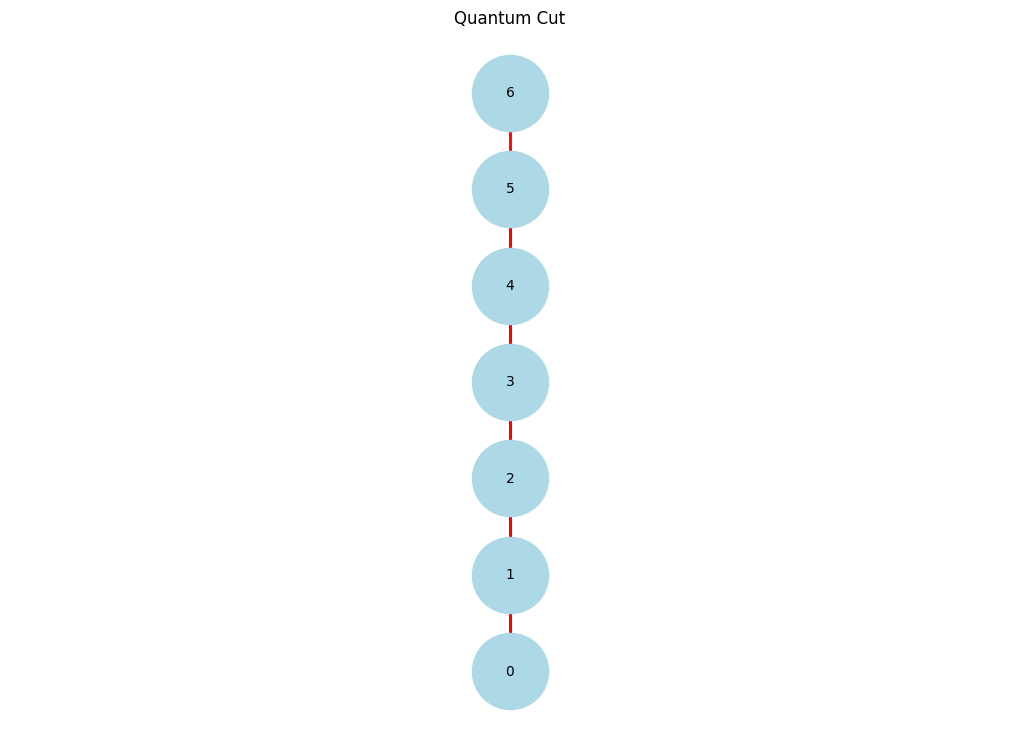

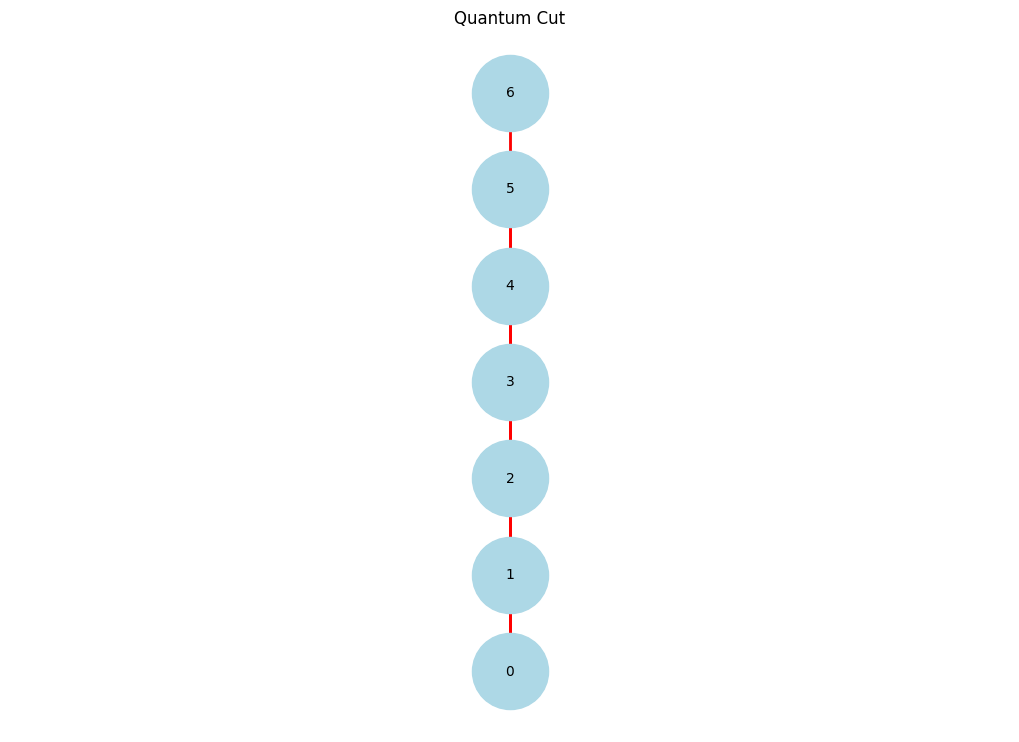

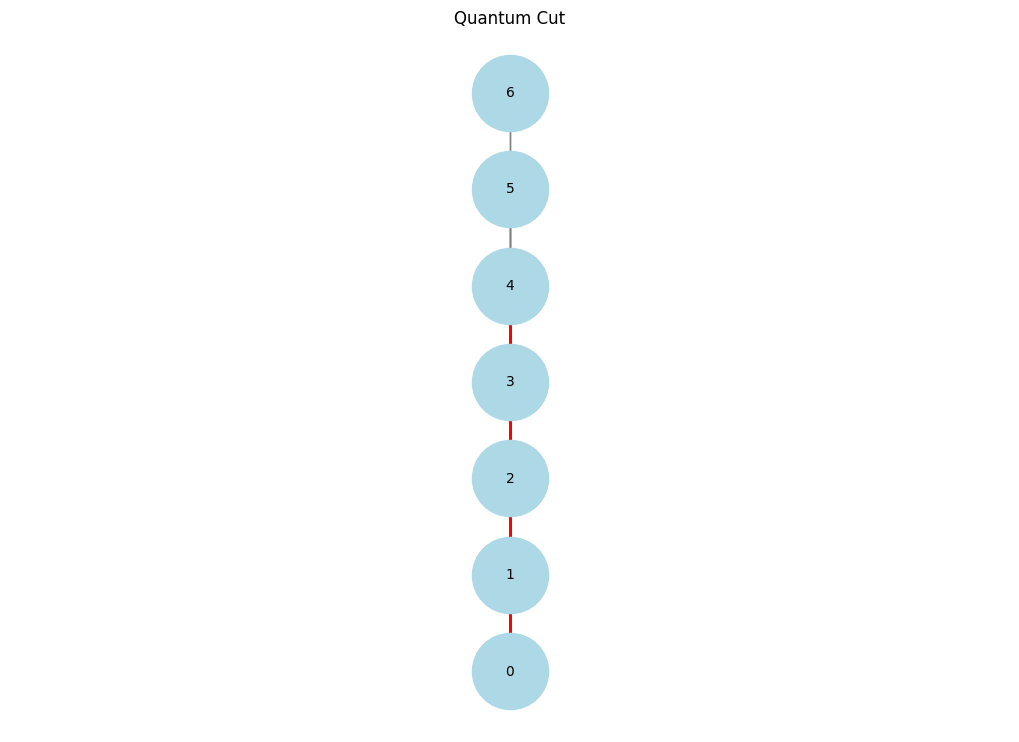

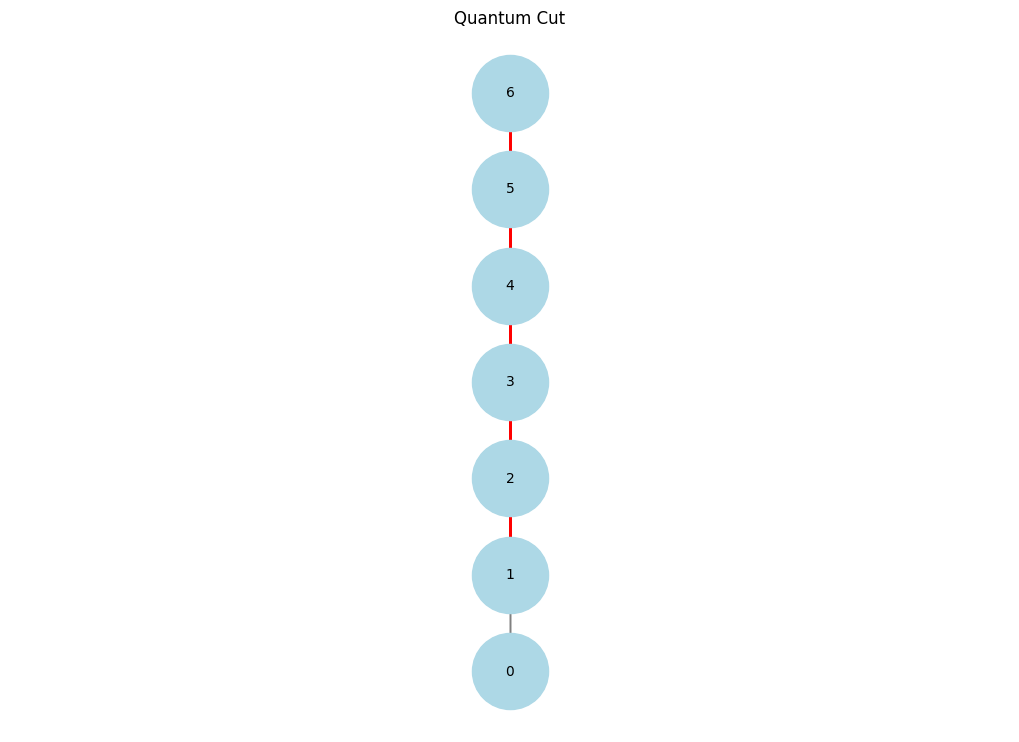

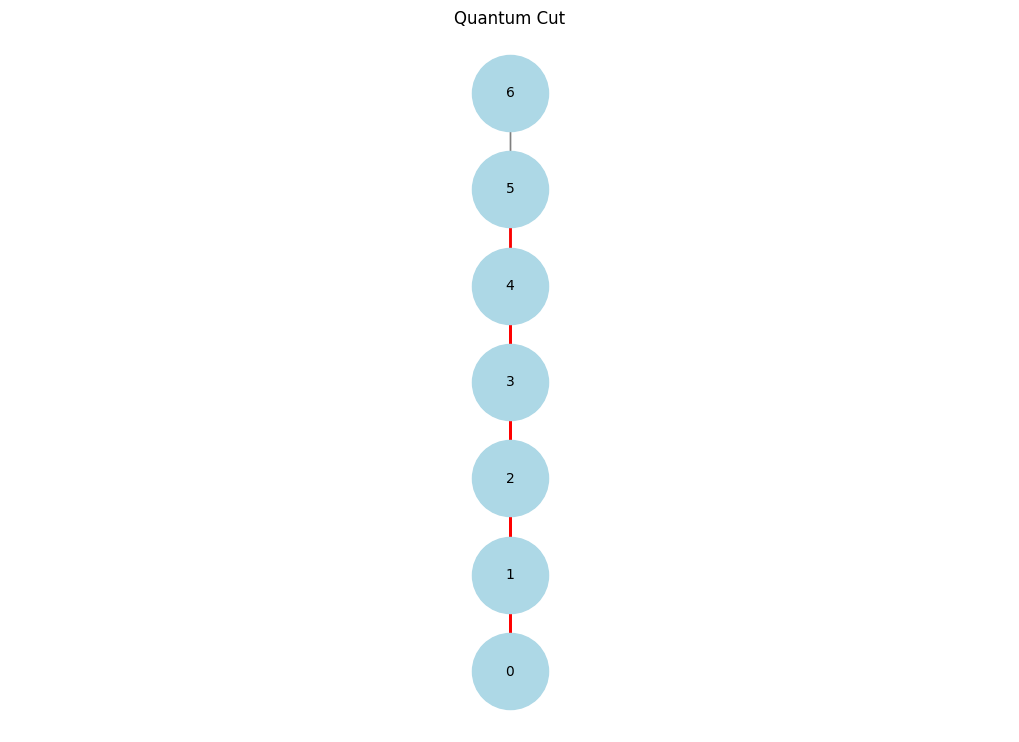

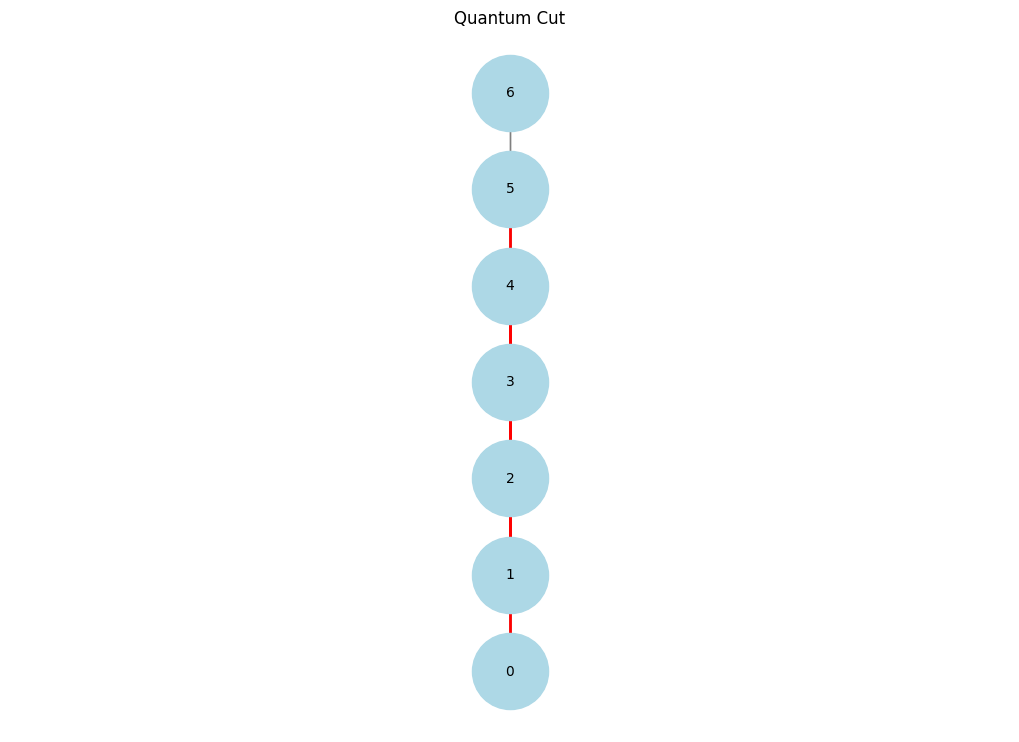

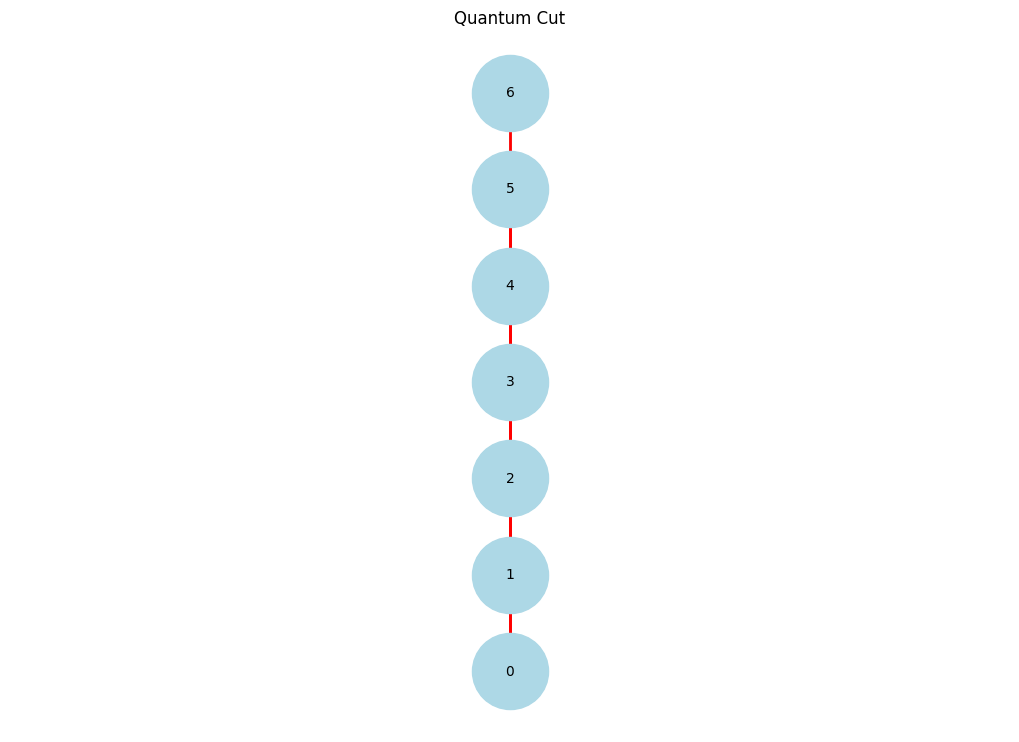

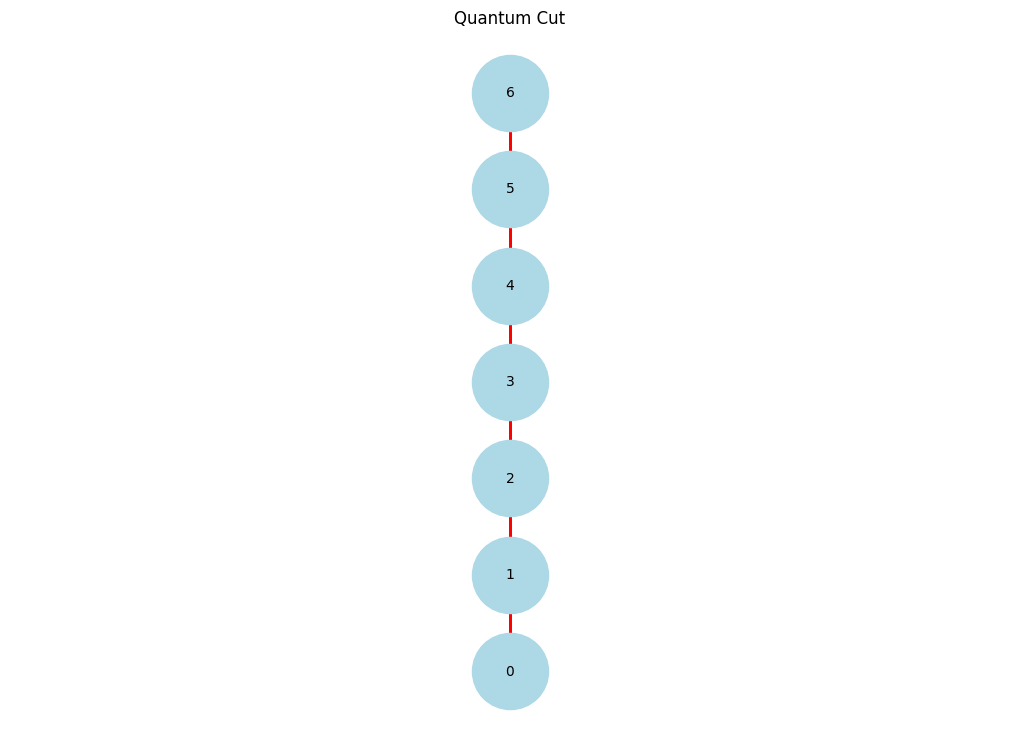

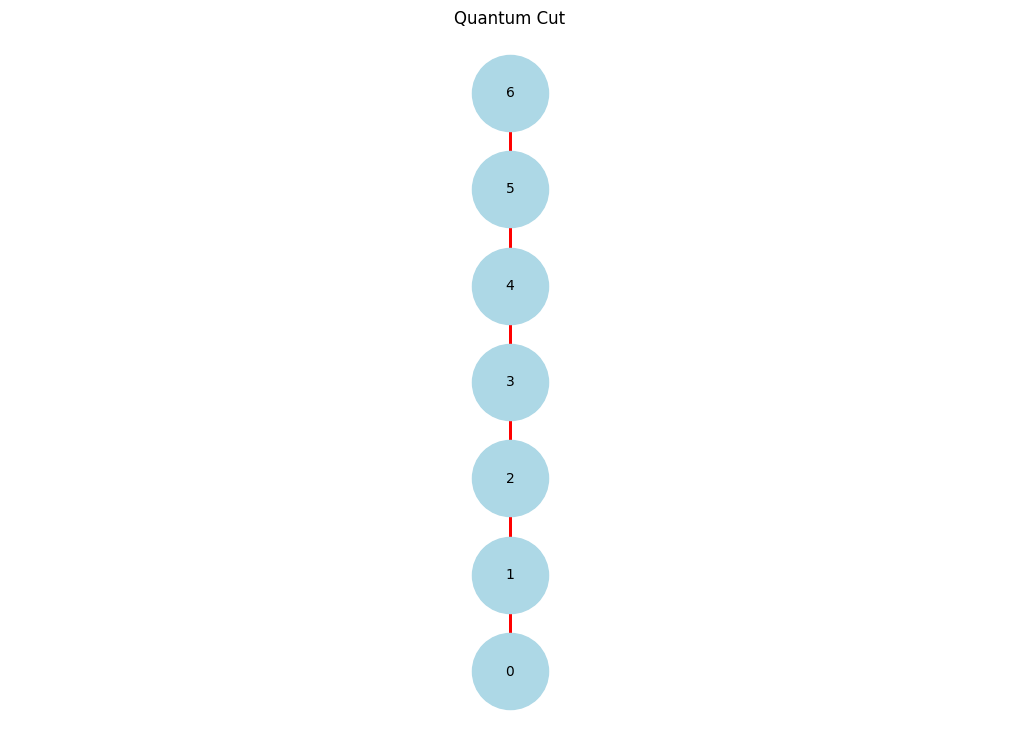

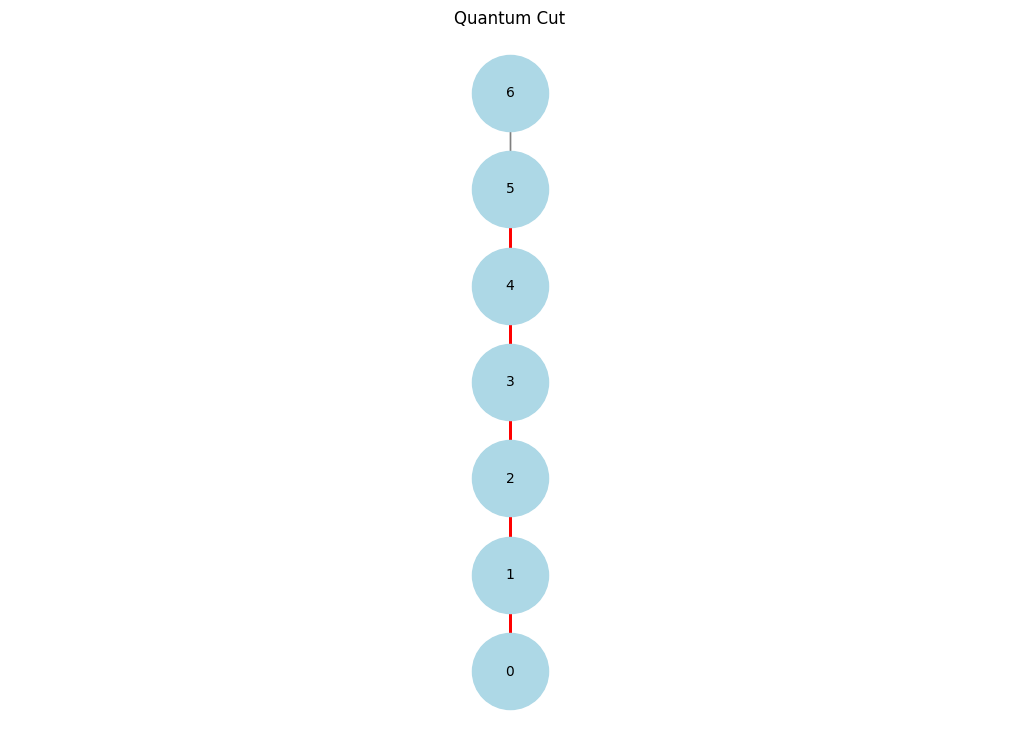

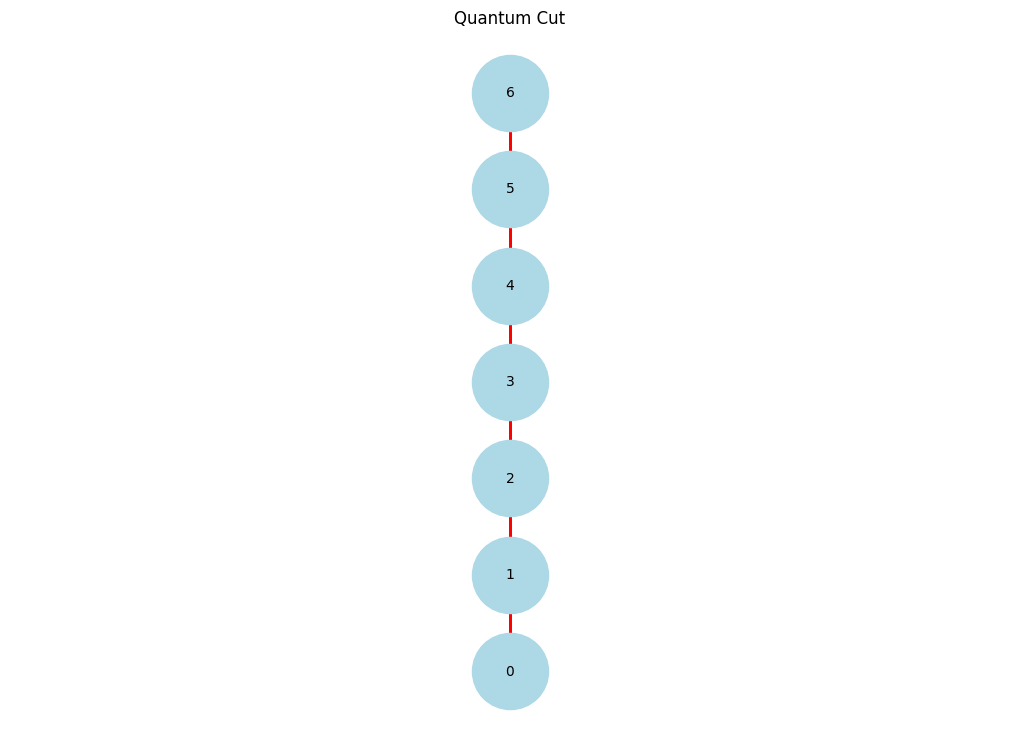

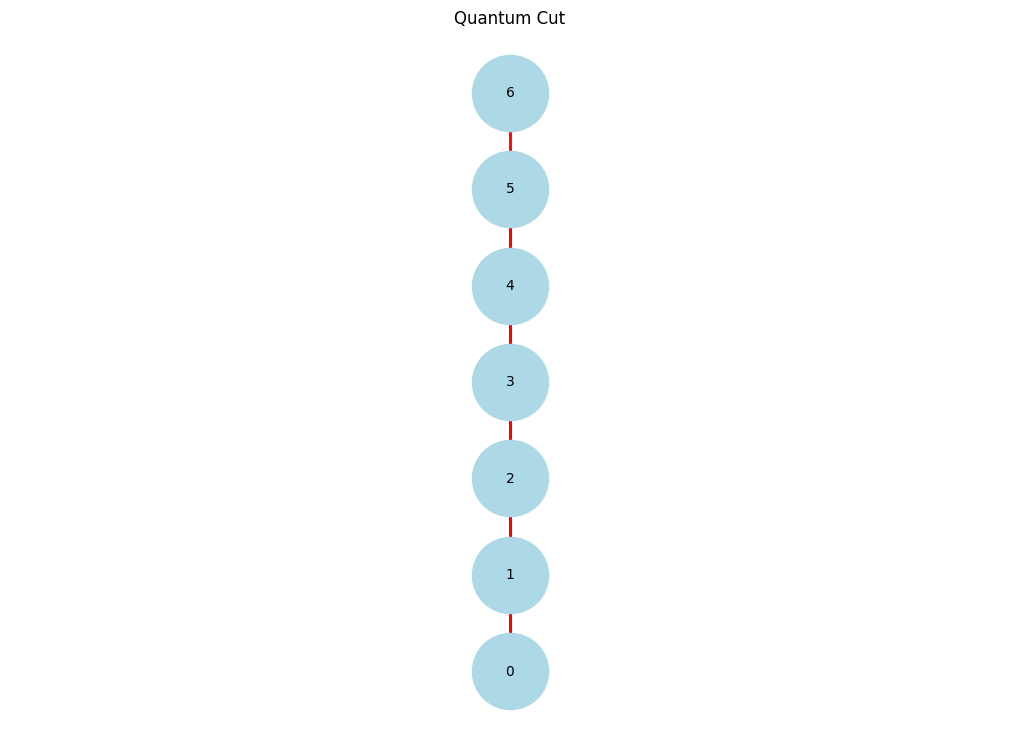

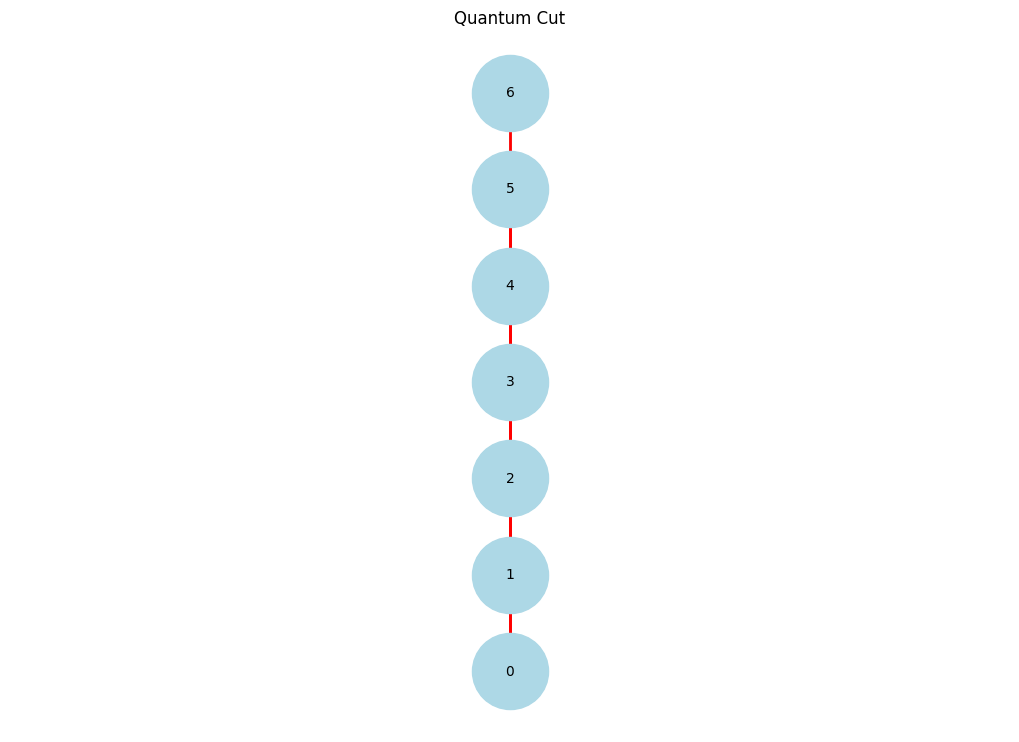

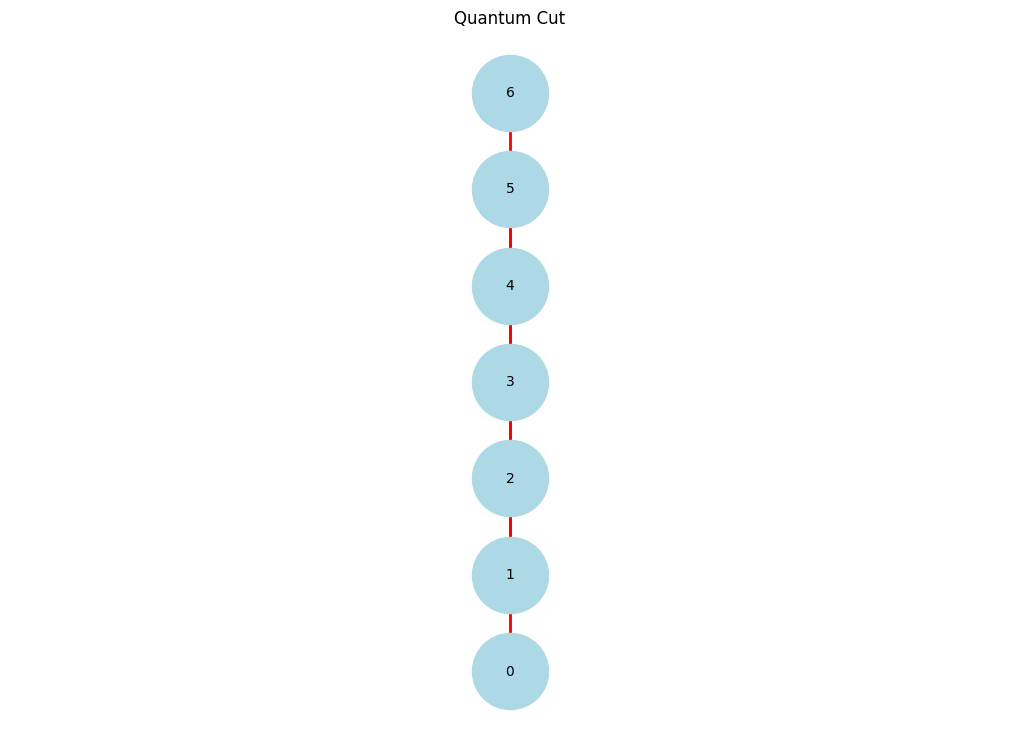

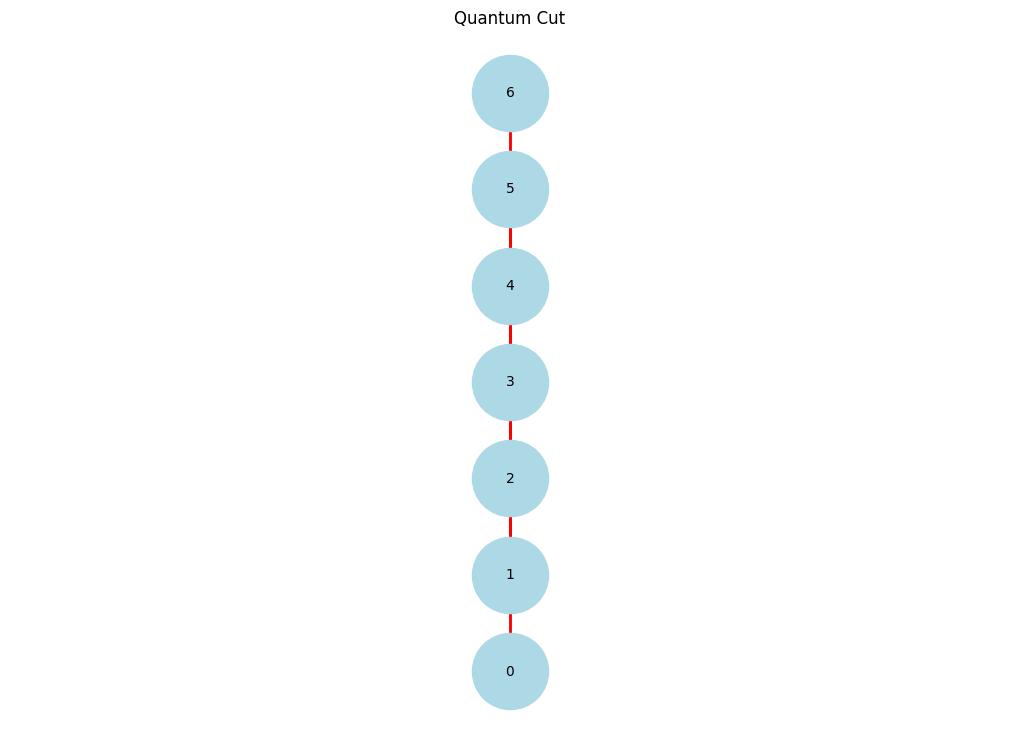

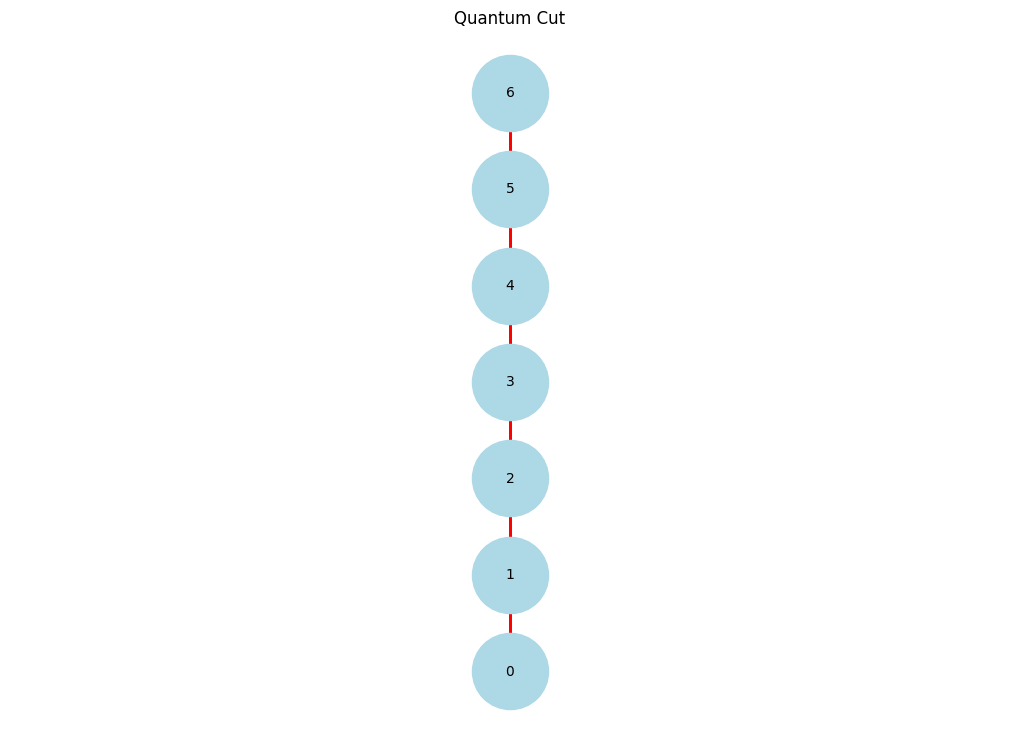

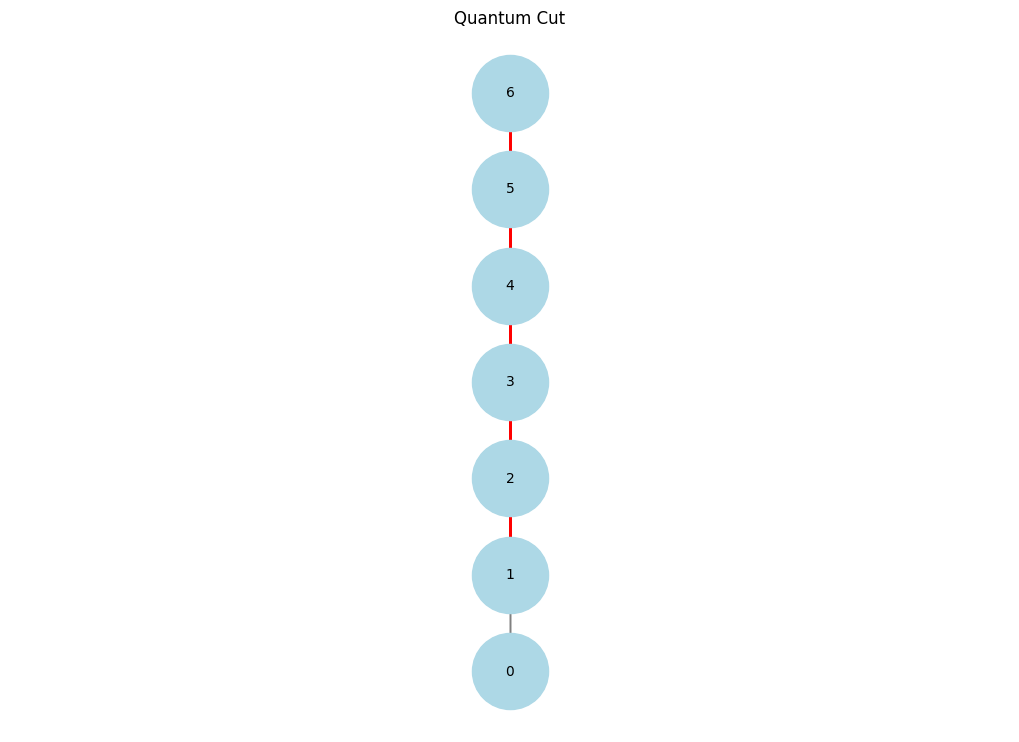

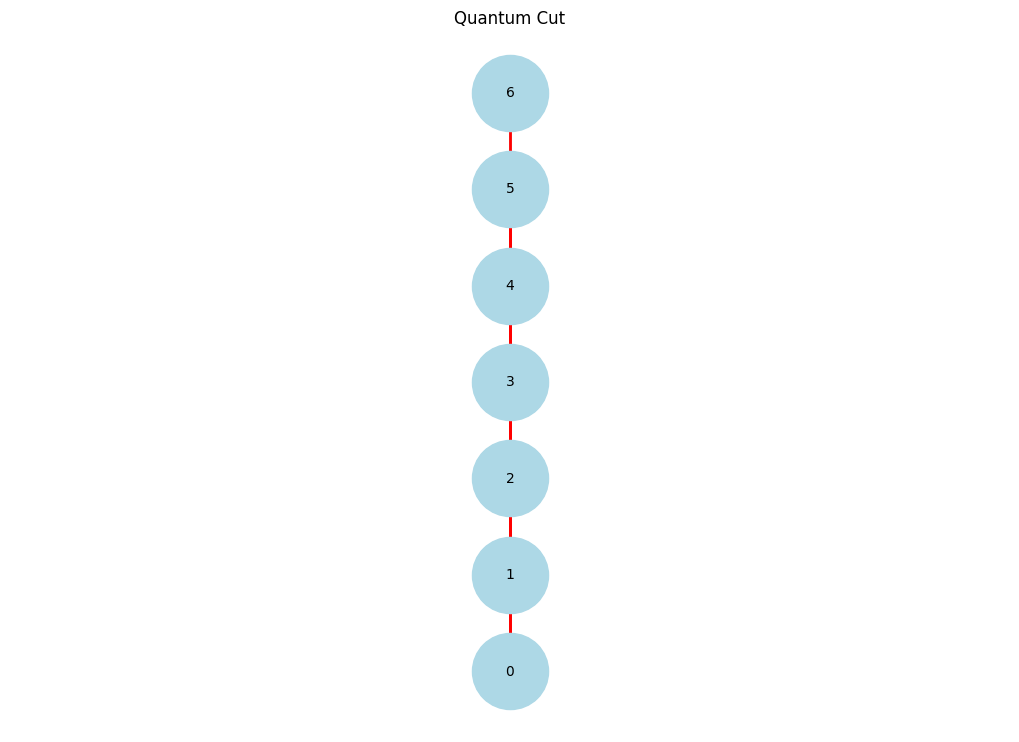

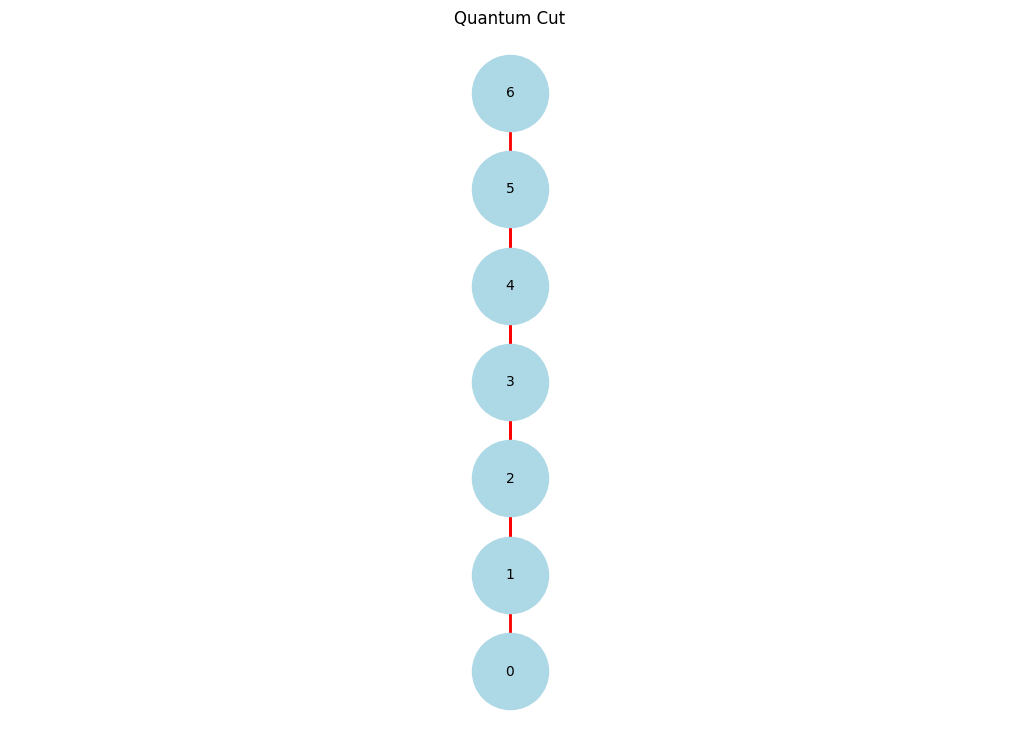

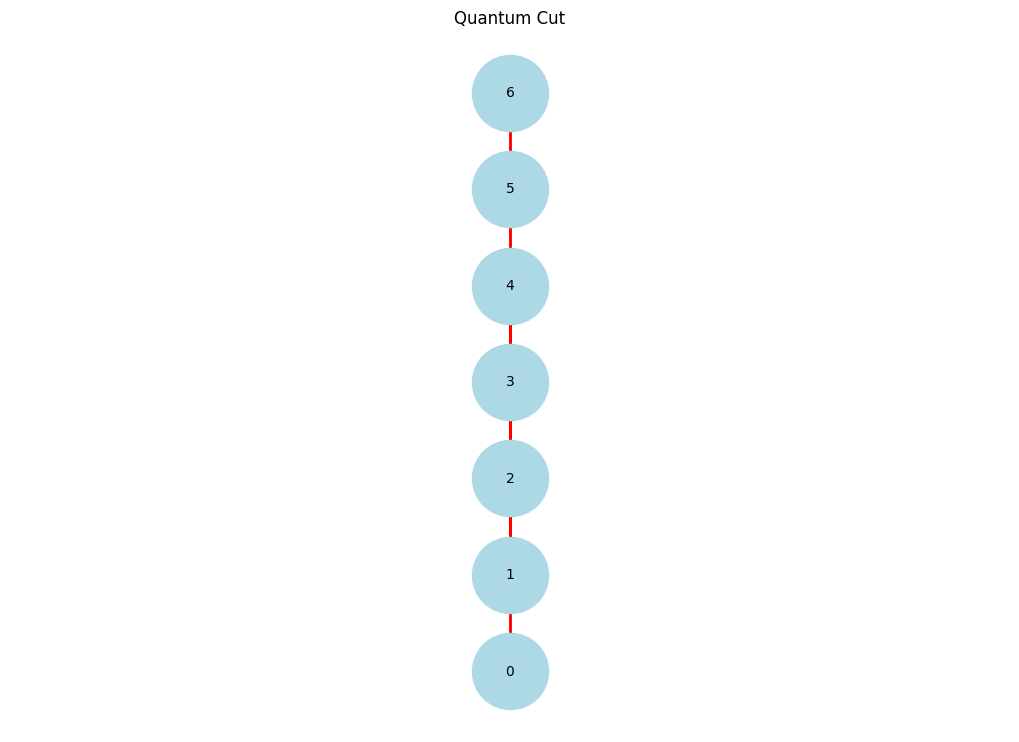

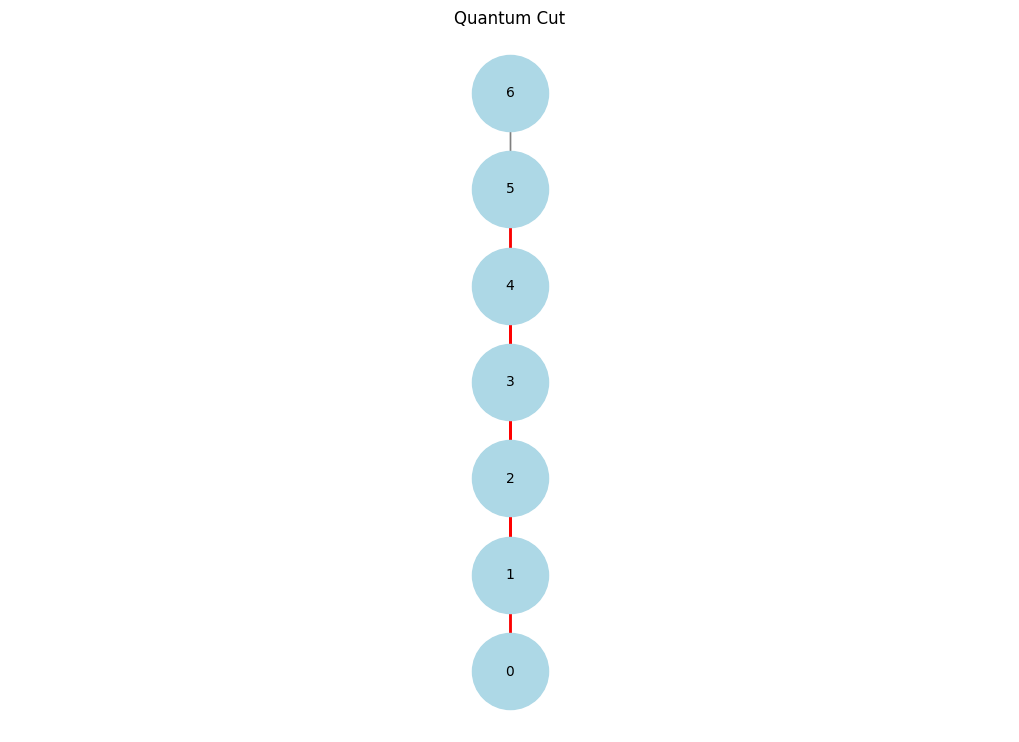

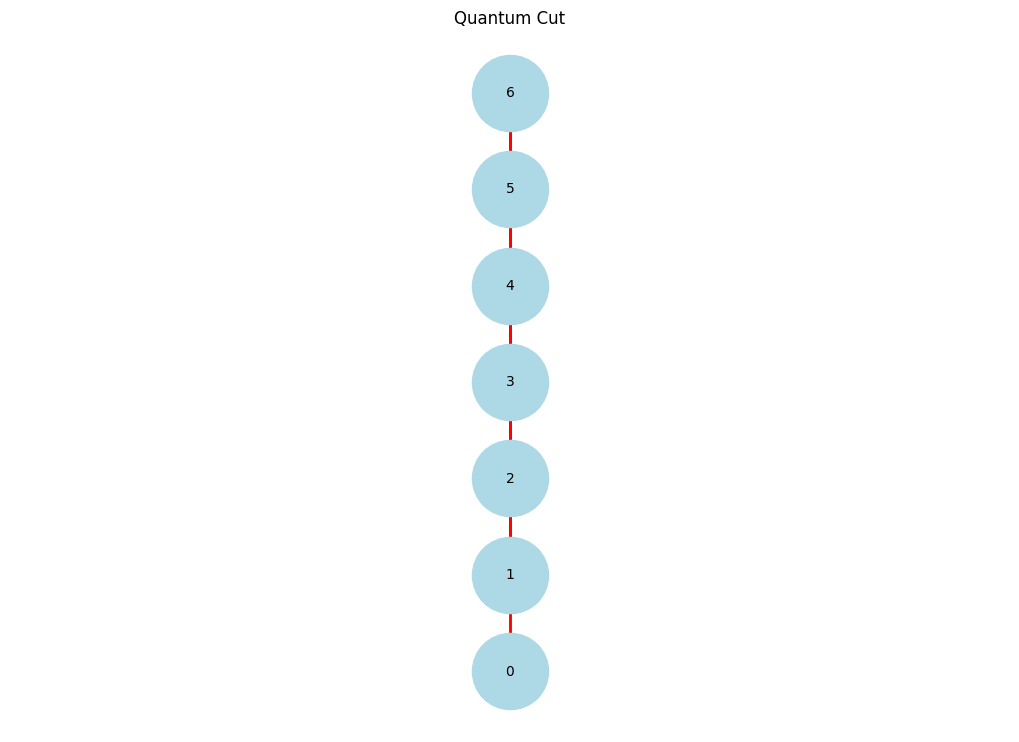

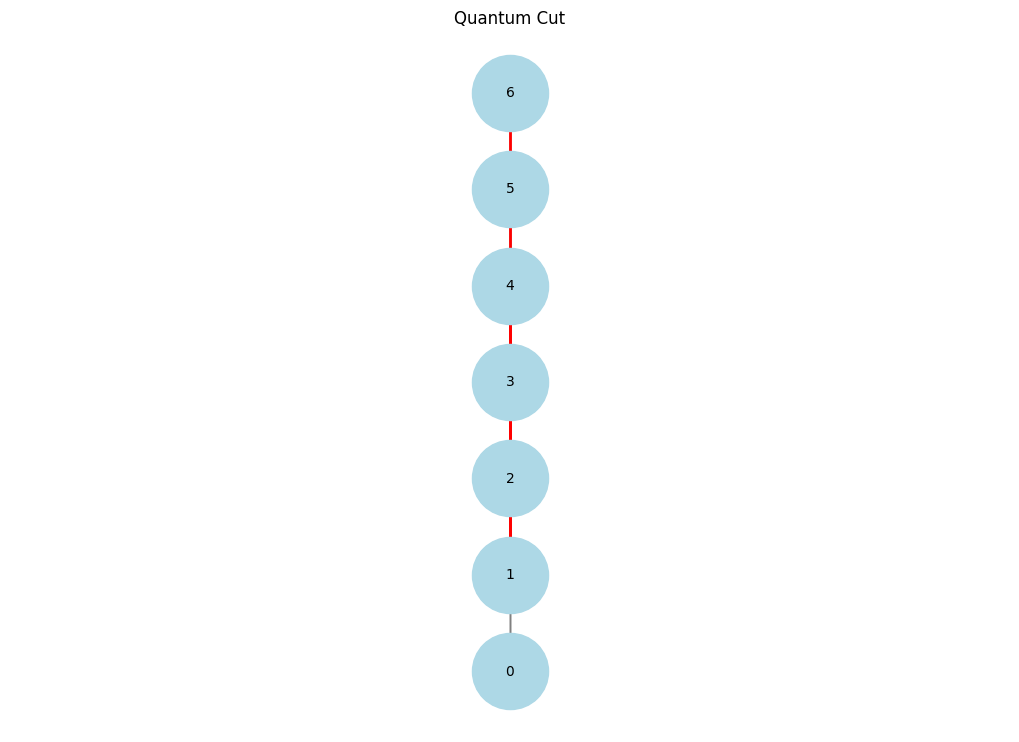

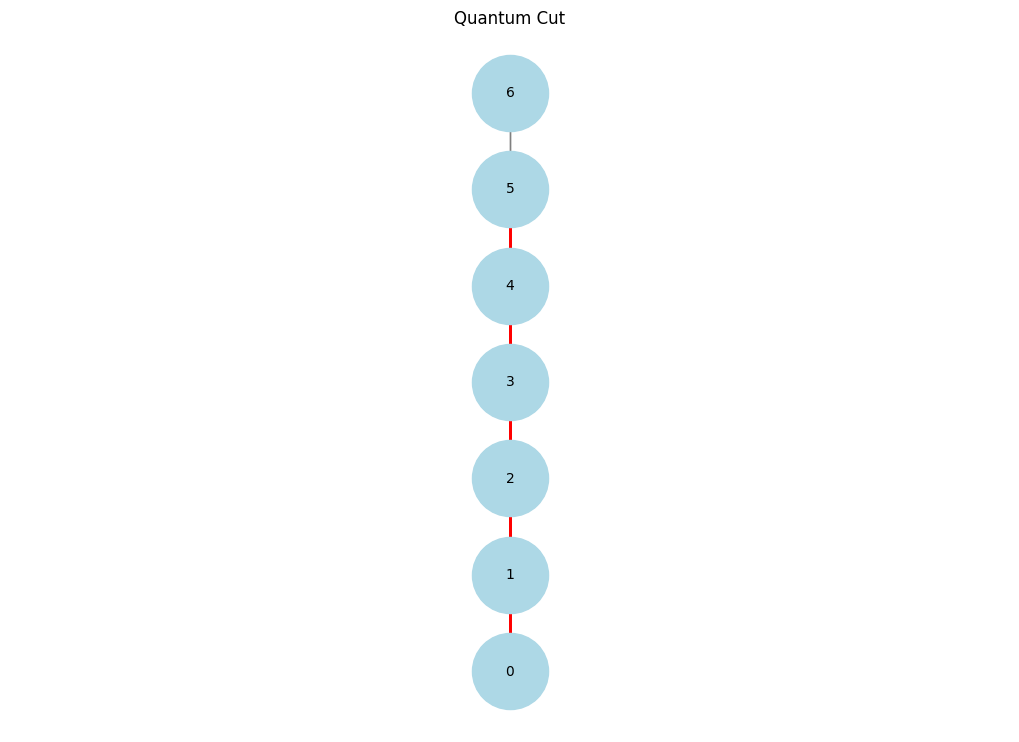

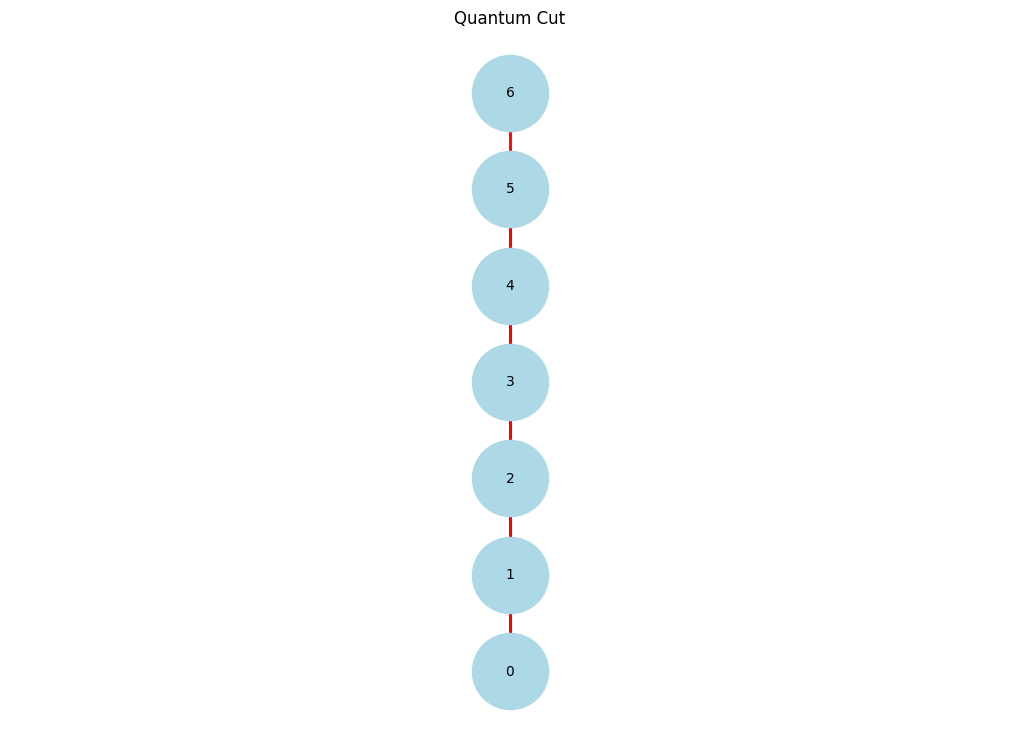

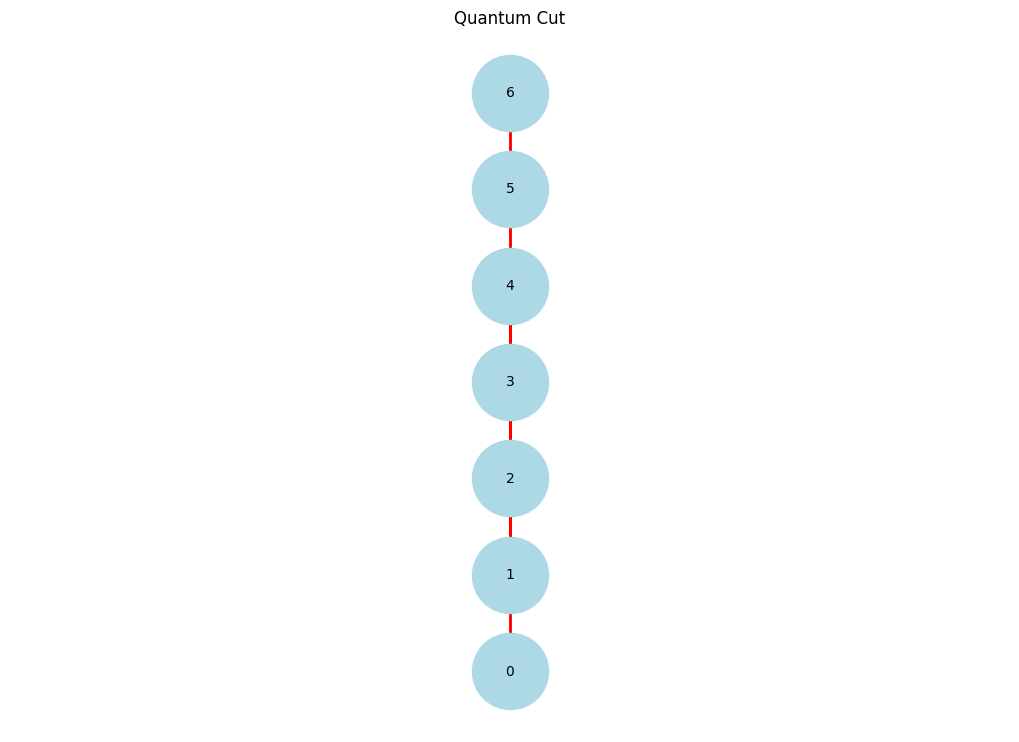

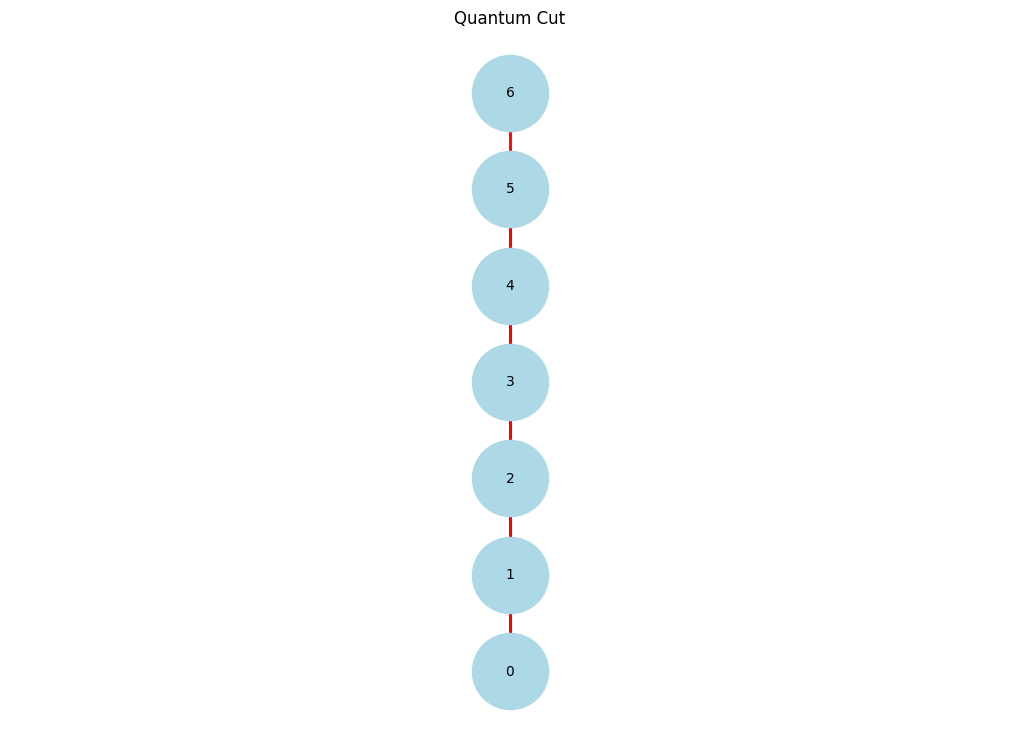

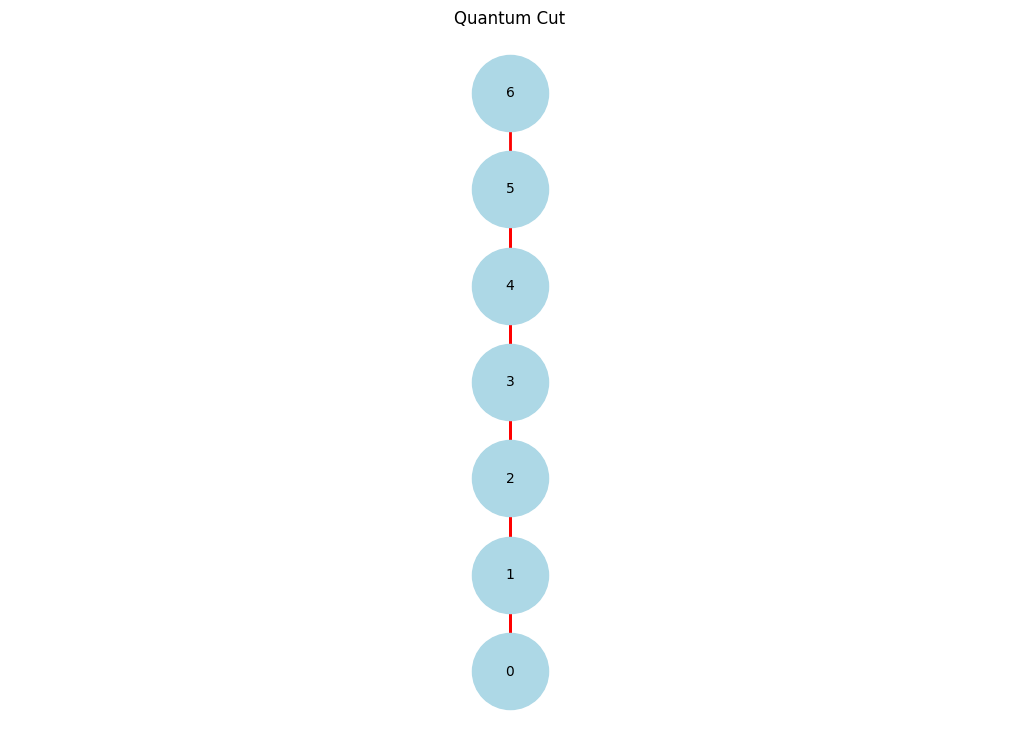

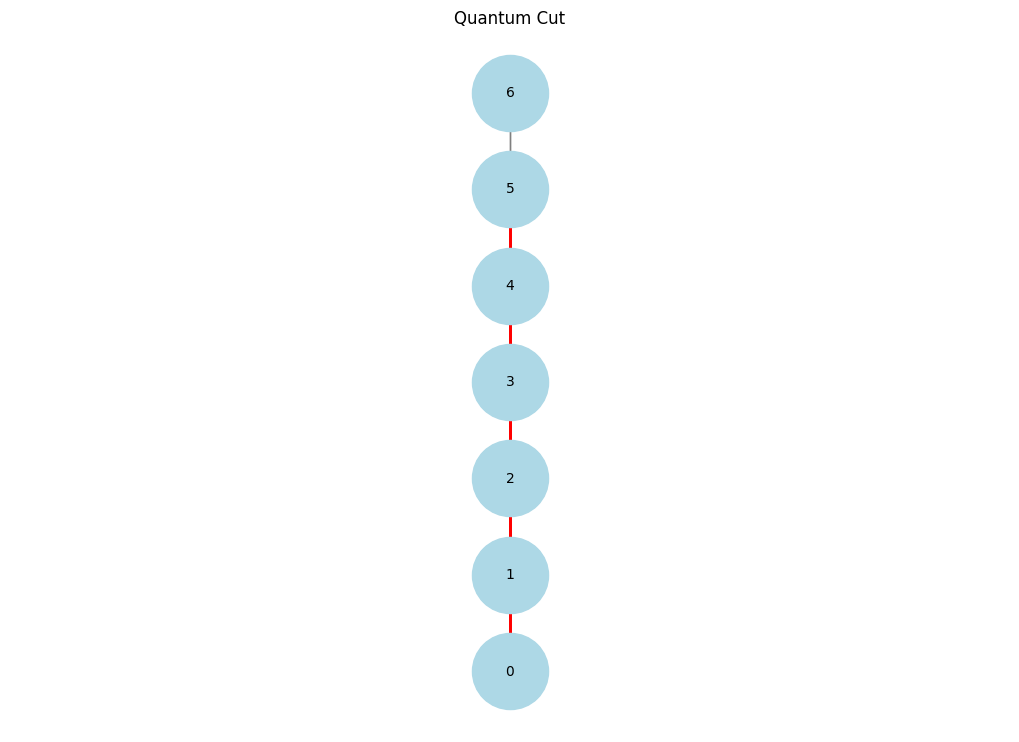

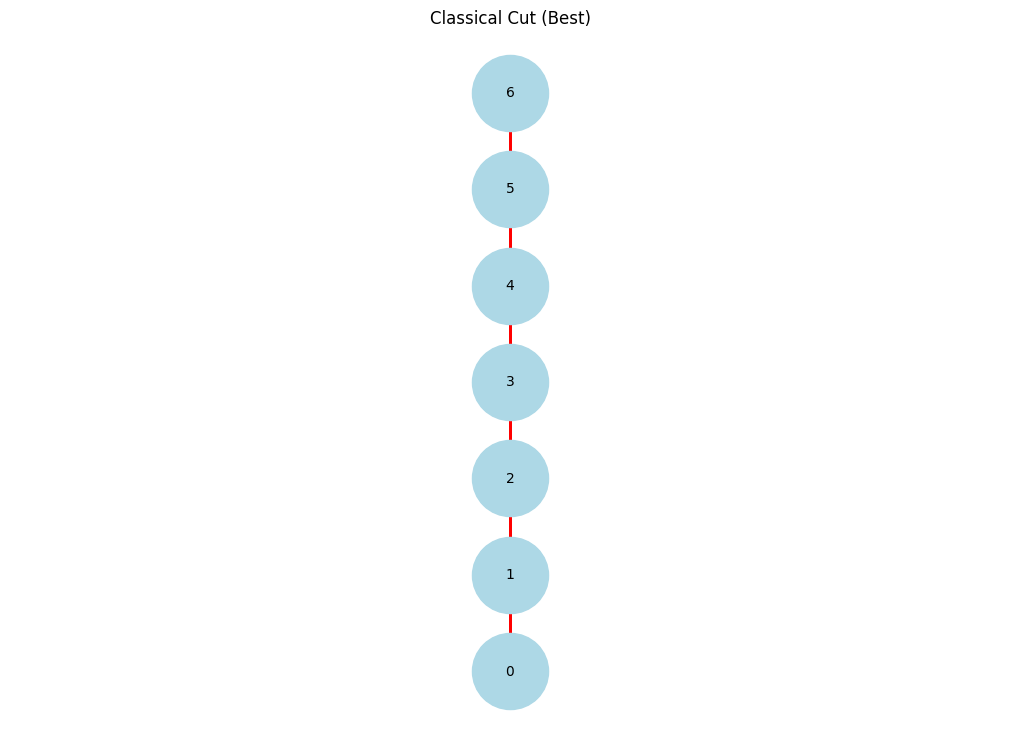

In [71]:
def get_cut_edges(G, cut_nodes):
    cut_edges = []
    for edge in G.edges():
        u, v = edge
        if (u in cut_nodes) != (v in cut_nodes):  # Edge crosses the cut
            cut_edges.append(edge)
    return cut_edges

# Visualize the cut edges
def visualize_cut(G, cut_nodes, title):
    pos = nx.bipartite_layout(G, nodes=df['patient'].unique())
    plt.figure(figsize=(10, 7))
    nx.draw(G, pos, with_labels=True, node_color='lightblue', edge_color='gray', node_size=3000, font_size=10)
    
    cut_edges = get_cut_edges(G, cut_nodes)
    nx.draw_networkx_edges(G, pos, edgelist=cut_edges, edge_color='red', width=2)
    
    plt.title(title)
    plt.show()

# Process the quantum cut
for cut in quantum_preds:
    visualize_cut(G, cut, 'Quantum Cut')

# Process the classical cut (choosing an example cut for visualization)
if cut_classic:
    best_cut = sub_lists[np.argmax(cut_classic)]  # Choose the best classical cut
    visualize_cut(G, best_cut, 'Classical Cut (Best)')
